In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from DataLoader import DataLoader
import datetime
import random
import warnings
from VocalFeatureExtractor import VocalFeatureExtractor
from BehaviourAnnotation import *
from BehaviourFeatureExtractor import BehaviourFeatureExtractor, plot_mouse_angle_to_pup, convert_seconds_to_frame
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import pprint
from matplotlib.collections import LineCollection
from colour import Color

## Reading and converting times ##

In [122]:
# from a datetime format string "minutes:seconds" return the number of seconds
def time_to_seconds(time):
    minutes, seconds = time.split(":")
    return int(minutes)*60 + int(seconds)

# from a value of seconds, return the corresponding minutes string minutes:string
def seconds_to_time(seconds):
    minutes = seconds // 60
    seconds = seconds % 60
    return str(int(minutes)) + ":" + str(int(seconds))

time = 382.266
print("time:", seconds_to_time(time))

actual_time = "6:27"
print("actual time:", actual_time, ", in_seconds:", time_to_seconds(actual_time))

time: 6:22
actual time: 6:27 , in_seconds: 387


#### Script to write to Behavior files ####

In [127]:
paths = ["data/VBQ0261L/VBQ0261L_240222_d1/VBQ0261L_240222_d1_Behavior/VBQ0261L_240222_d1_BehavSummary.csv",
        "data/VBQ0261L/VBQ0261L_240226_d5/VBQ0261L_240226_d5_Behavior/VBQ0261L_240226_d5_BehavSummary.csv",
        "data/VBQ0261L/VBQ0261L_240227_d6/VBQ0261L_240227_d6_Behavior/VBQ0261L_240227_d6_BehavSummary.csv",
        "data/VBQ0261L/VBQ0261L_240225_d4/VBQ0261L_240225_d4_Behavior/VBQ0261L_240225_d4_BehavSummary.csv",
        "data/VBQ0261L/VBQ0261L_240224_d3/VBQ0261L_240224_d3_Behavior/VBQ0261L_240224_d3_BehavSummary.csv",
        "data/VBQ0261L/VBQ0261L_240223_d2/VBQ0261L_240223_d2_Behavior/VBQ0261L_240223_d2_BehavSummary.csv"]
paths_save = ["data/VBQ0261L/VBQ0261L_240222_d1/VBQ0261L_240222_d1_Behavior/VBQ0261L_240222_d1_BehavSummary_time_minutes.csv",
              "data/VBQ0261L/VBQ0261L_240226_d5/VBQ0261L_240226_d5_Behavior/VBQ0261L_240226_d5_BehavSummary_time_minutes.csv",
            "data/VBQ0261L/VBQ0261L_240227_d6/VBQ0261L_240227_d6_Behavior/VBQ0261L_240227_d6_BehavSummary_time_minutes.csv",
            "data/VBQ0261L/VBQ0261L_240225_d4/VBQ0261L_240225_d4_Behavior/VBQ0261L_240225_d4_BehavSummary_time_minutes.csv",
            "data/VBQ0261L/VBQ0261L_240224_d3/VBQ0261L_240224_d3_Behavior/VBQ0261L_240224_d3_BehavSummary_time_minutes.csv",
            "data/VBQ0261L/VBQ0261L_240223_d2/VBQ0261L_240223_d2_Behavior/VBQ0261L_240223_d2_BehavSummary_time_minutes.csv"]

# paths += [ "data/MBI5335RR/MBI5335RR_240304_d1/MBI5335RR_240304_d1_Behavior/MBI5335RR_240304_d1_BehavSummary.csv",
#           "data/MBI5335RR/MBI5335RR_240305_d2/MBI5335RR_240305_d2_Behavior/MBI5335RR_240305_d2_BehavSummary.csv",
#           "data/MBI5335RR/MBI5335RR_240306_d3/MBI5335RR_240306_d3_Behavior/MBI5335RR_240306_d3_BehavSummary.csv",
#           "data/MBI5335RR/MBI5335RR_240307_d4/MBI5335RR_240307_d4_Behavior/MBI5335RR_240307_d4_BehavSummary.csv",
#           "data/MBI5335RR/MBI5335RR_240308_d5/MBI5335RR_240308_d5_Behavior/MBI5335RR_240308_d5_BehavSummary.csv",
#           "data/MBI5335RR/MBI5335RR_240309_d6/MBI5335RR_240309_d6_Behavior/MBI5335RR_240309_d6_BehavSummary.csv"
# ]

# paths_save += [ "data/MBI5335RR/MBI5335RR_240304_d1/MBI5335RR_240304_d1_Behavior/MBI5335RR_240304_d1_BehavSummary_time_minutes.csv",
#           "data/MBI5335RR/MBI5335RR_240305_d2/MBI5335RR_240305_d2_Behavior/MBI5335RR_240305_d2_BehavSummary_time_minutes.csv",
#           "data/MBI5335RR/MBI5335RR_240306_d3/MBI5335RR_240306_d3_Behavior/MBI5335RR_240306_d3_BehavSummary_time_minutes.csv",
#           "data/MBI5335RR/MBI5335RR_240307_d4/MBI5335RR_240307_d4_Behavior/MBI5335RR_240307_d4_BehavSummary_time_minutes.csv",
#           "data/MBI5335RR/MBI5335RR_240308_d5/MBI5335RR_240308_d5_Behavior/MBI5335RR_240308_d5_BehavSummary_time_minutes.csv",
#           "data/MBI5335RR/MBI5335RR_240309_d6/MBI5335RR_240309_d6_Behavior/MBI5335RR_240309_d6_BehavSummary_time_minutes.csv"
# ]


for path, path_save in zip(paths, paths_save): 
    # print(path)
    # print(path_save)
    df = pd.read_csv(path)

    # convert the "PupDispDropSecs" and "BehavRecdTrialEndSecs" column to a minutes string
    df["PupDispDropSecs_minutes"] = df["PupDispDropSecs"].apply(seconds_to_time)
    df["BehavRecdTrialEndSecs_minutes"] = df["BehavRecdTrialEndSecs"].apply(seconds_to_time)

    # reorder the columns
    cols = ['Group', 'AnimalID', 'ExptID', 'TrialNum',
        'PupDisplPosition', 'BehavRecdTrialStartSecs', 'BehavRecdTrialEndSecs', 'BehavRecdTrialEndSecs_minutes',
        'PupDispDropSecs', 'PupDispDropSecs_minutes', 'MouseFirstPickUpPupSecs', 'DropPupNestSecs',
        'TrialDesignAchieved', 'EndHabituation', 'OptoUsed', 'OptoStartSecs',
        'OptoEndSecs', 'Features', 'Notes']

    df = df[cols]

    df.to_csv(path_save, index = False)


## Reading and loading Data ##

#### Loading and processing all trials from all days #####

In [2]:
data_dir = "data"
DL = DataLoader(data_dir, path_to_config_file="config.json")
BF = BehaviourFeatureExtractor("config.json")
VF = VocalFeatureExtractor("config.json")

#### Creating dictionary structure for lookup #####

In [3]:
mouse_ids = ["MBI5335RR", "VBQ0261L"]
days = [f"d{i}" for i in range(1, 7)]

experiment_data = {}

for ms_id in mouse_ids:
    experiment_data[ms_id] = {}
    for d in days:
        # Load data
        data = DL.get_data_for_experiment(mouse_id = ms_id,
                                          day = d)
        if data is None:
            print("Data not found for mouse", ms_id, "on day", d)
            continue

        experiment_data[ms_id][d] = data

        df_DLC = experiment_data[ms_id][d]["Behavior"]["df_dlc"].copy()
        df_Avi = experiment_data[ms_id][d]["Avisoft"]["df"].copy()
        df_summary = experiment_data[ms_id][d]["Behavior"]["df_summary"].copy()

        # align USV data to DLC data
        df_DLC_processed, _ = BF.process_DLC(df_DLC.copy(), df_summary)
        trials, df_DLC, df_USV = VF.process_USV(df_Avi, df_summary, df_DLC_processed)
        experiment_data[ms_id][d]["trials"] =  trials

----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance t

## Data Exploration ##

##### Day 1 trials #####

In [12]:
# get data for d1 experiment
day1_data = DL.get_data_for_experiment(mouse_id = "MBI5335RR",
                                       day = "d1")

# fill out dataframes
df_summary = day1_data['Behavior']['df_summary']
df_DLC = day1_data['Behavior']['df_dlc']

In [13]:
BF = BehaviourFeatureExtractor("config.json")
df_DLC_updated, trials_dict = BF.process_DLC(df_DLC, df_summary)

----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance t

## Feature Extraction ##

### BehavSummary + DLC  ###

- **BehavSummary + DLC**
    - Define behavioral windows (e.g: -2 to +2 seconds of each behavioral event)
    - Define behavioral windows pre-event (e.g: -x to 0 seconds of each behavioral event)
    - Find behavioral events (from BehavSummaries; *timing info*) in the DLC position data (*x,y info*):
        - at each behavioral event, where was the mouse and the pup located in the arena?
            - how far was the mouse from the pup?
            - what was the head direction of the mouse (towards the pup) at that point?
            - ‘approach’ trajectory: parse out trajectory of mouse towards pup and try to find a segment which is more ‘direct’/ higher speed
        - For the pre-event behavioral window of MouseFirstPickUpSecs: what is the speed of the mouse? What is the head direction of the mouse?

In [15]:
BF = BehaviourFeatureExtractor("config.json")

xmax, ymax = BF.config["arena_bounds"]["xmax"], BF.config["arena_bounds"]["ymax"]
xmin, ymin = BF.config["arena_bounds"]["xmin"], BF.config["arena_bounds"]["ymin"]

trial_1_DLC, trial_mask = BF.extract_trial_from_DLC(df_DLC, df_summary, trial_num = 1)
trial_1_DLC = BF.process_trial(trial_1_DLC, trial_num = 1, interpolate_low_likelihoods = True)


----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup


Display full trial

<Axes: xlabel='pup_y'>

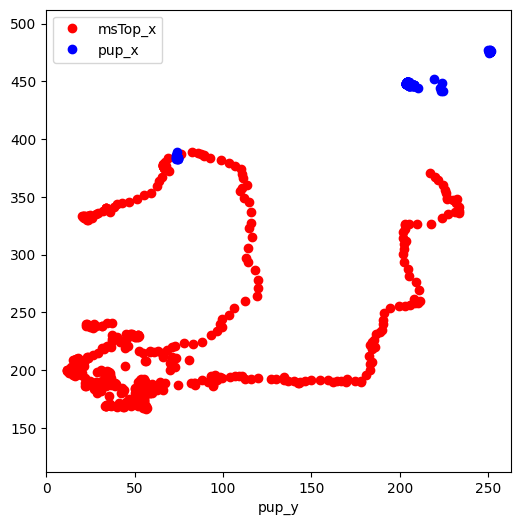

In [16]:
# plot mouse and pup positions
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

trial_1_DLC.plot(x='msTop_y', y='msTop_x', style='o', ax=ax, xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'r')
trial_1_DLC.plot(x='pup_y', y='pup_x', style='o', ax=ax,xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'b')

#### Quality Checks on low likelihood coords ####

Visualization noisy data points and comparing with nest coordinates

----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup


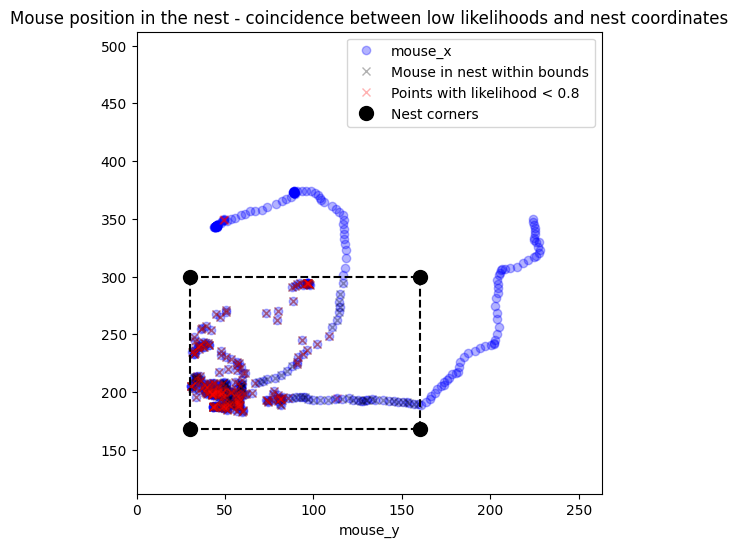

In [17]:
#### Pick trial and parameters ####
n = 1 # pick n in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
threshold = 0.8
BF.likelihood_threshold = 0.8
trial_DLC, mask_trial = BF.extract_trial_from_DLC(df_DLC, df_summary, trial_num = n)
trial_DLC = BF.process_trial(trial_DLC, trial_num = n, interpolate_low_likelihoods = True)
trial_DLC = trials_dict[n]

#### Retrieve masks #####
# retrieve mask of in_nest coordinates
mask_nest = (trial_DLC["in_nest"] == True)
# retrieve points with likelihood under 80
mask_low_likelihood = (trial_DLC["mouse_likelihood"] < threshold)
# plot average of center nest points
nest_avg_x, nest_avg_y = trial_DLC["centerNest_x"].mean(), trial_DLC["centerNest_y"].mean()

#### PLOT ####
# plot mouse position and highlight low likelihood points and points in the nest
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
trial_DLC.plot(x='mouse_y', y='mouse_x', style='o', ax=ax, xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'blue', alpha = 0.3)
trial_DLC[mask_nest].plot(x='mouse_y', y='mouse_x', style='x', ax=ax, xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'black', alpha = 0.3, label = f"Mouse in nest within bounds")
trial_DLC[mask_low_likelihood].plot(x='mouse_y', y='mouse_x', style='x', ax=ax, xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'r', alpha = 0.3, label = f"Points with likelihood < {threshold}")

# draw nest bounds in plot
nest_bounds = BF.config["nest_bounds"]

# plot all four nest corners and draw dashed lines between them
ax.plot(nest_bounds["ymin"], nest_bounds["xmin"], 'o', color = 'black', markersize = 10, label = "Nest corners") # bottom left corner
ax.plot(nest_bounds["ymax"], nest_bounds["xmin"], 'o', color = 'black', markersize = 10) # bottom right corner
ax.plot(nest_bounds["ymin"], nest_bounds["xmax"], 'o', color = 'black', markersize = 10) # top left corner
ax.plot(nest_bounds["ymax"], nest_bounds["xmax"], 'o', color = 'black', markersize = 10) # top right corner

# draw dashed lines between nest corners
ax.plot([nest_bounds["ymin"], nest_bounds["ymax"]], [nest_bounds["xmin"], nest_bounds["xmin"]], 'k--')
ax.plot([nest_bounds["ymin"], nest_bounds["ymax"]], [nest_bounds["xmax"], nest_bounds["xmax"]], 'k--')
ax.plot([nest_bounds["ymin"], nest_bounds["ymin"]], [nest_bounds["xmin"], nest_bounds["xmax"]], 'k--')
ax.plot([nest_bounds["ymax"], nest_bounds["ymax"]], [nest_bounds["xmin"], nest_bounds["xmax"]], 'k--')

ax.set_title("Mouse position in the nest - coincidence between low likelihoods and nest coordinates") # add title

ax.legend() # plot legend

Visualizing interpolated points

----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
Trial 3 started at 415.2 and ended at 494.93333333333334
Trial 3 started at 0:06:55.200000 and ended at 0:08:14.933333


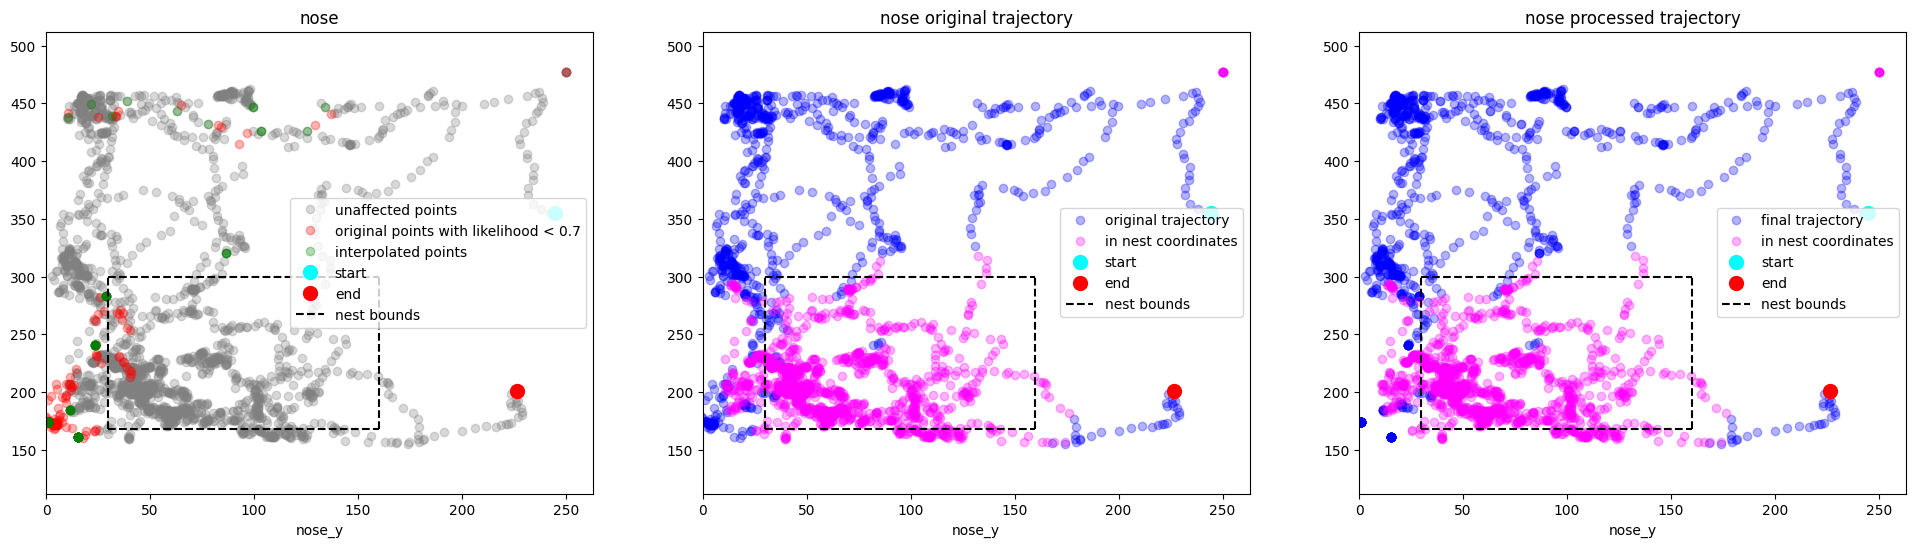

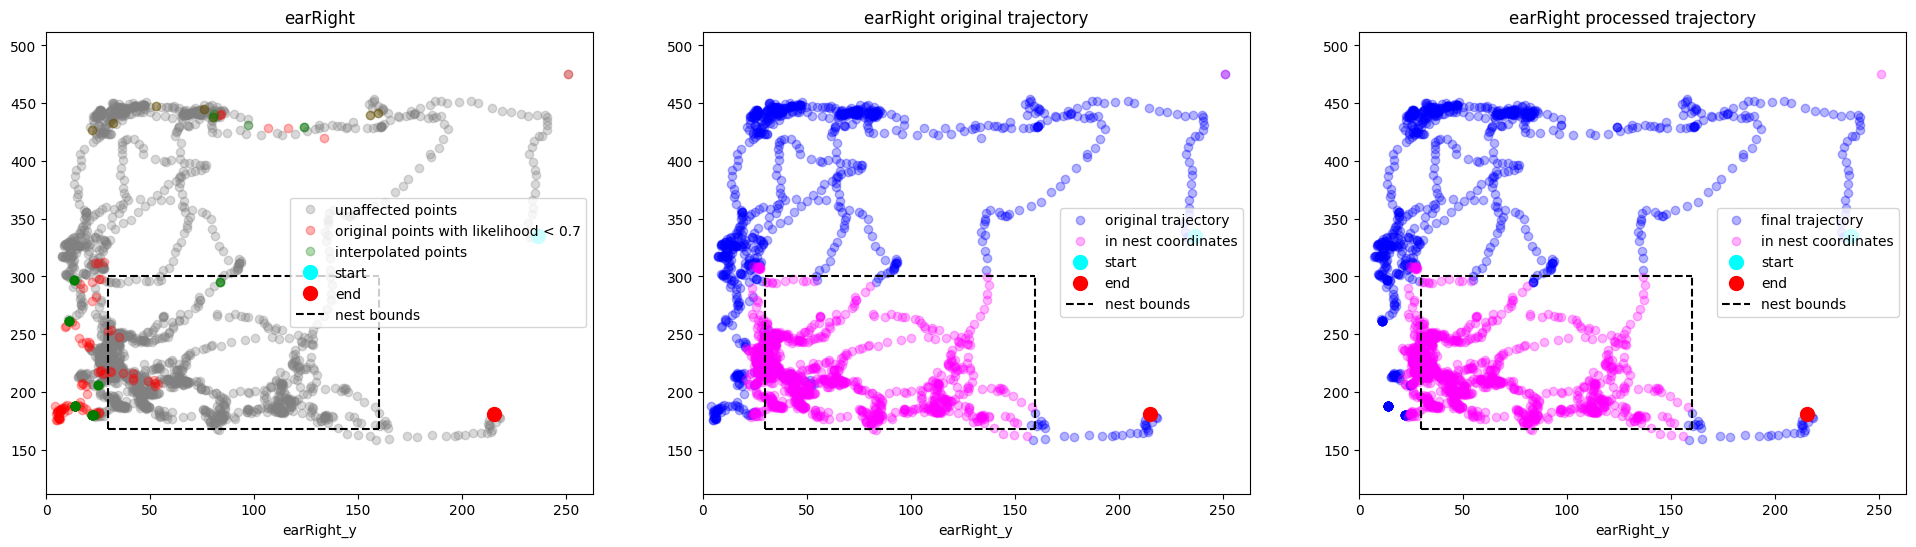

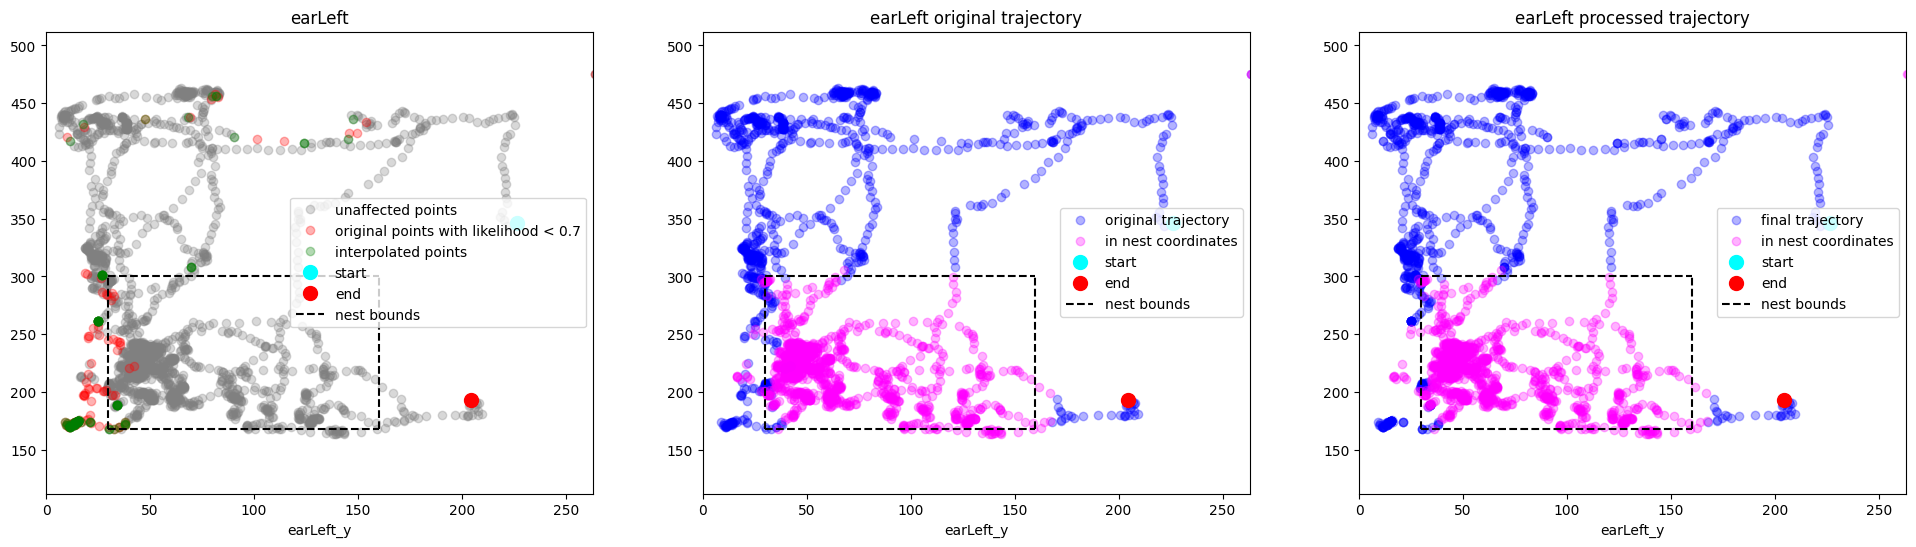

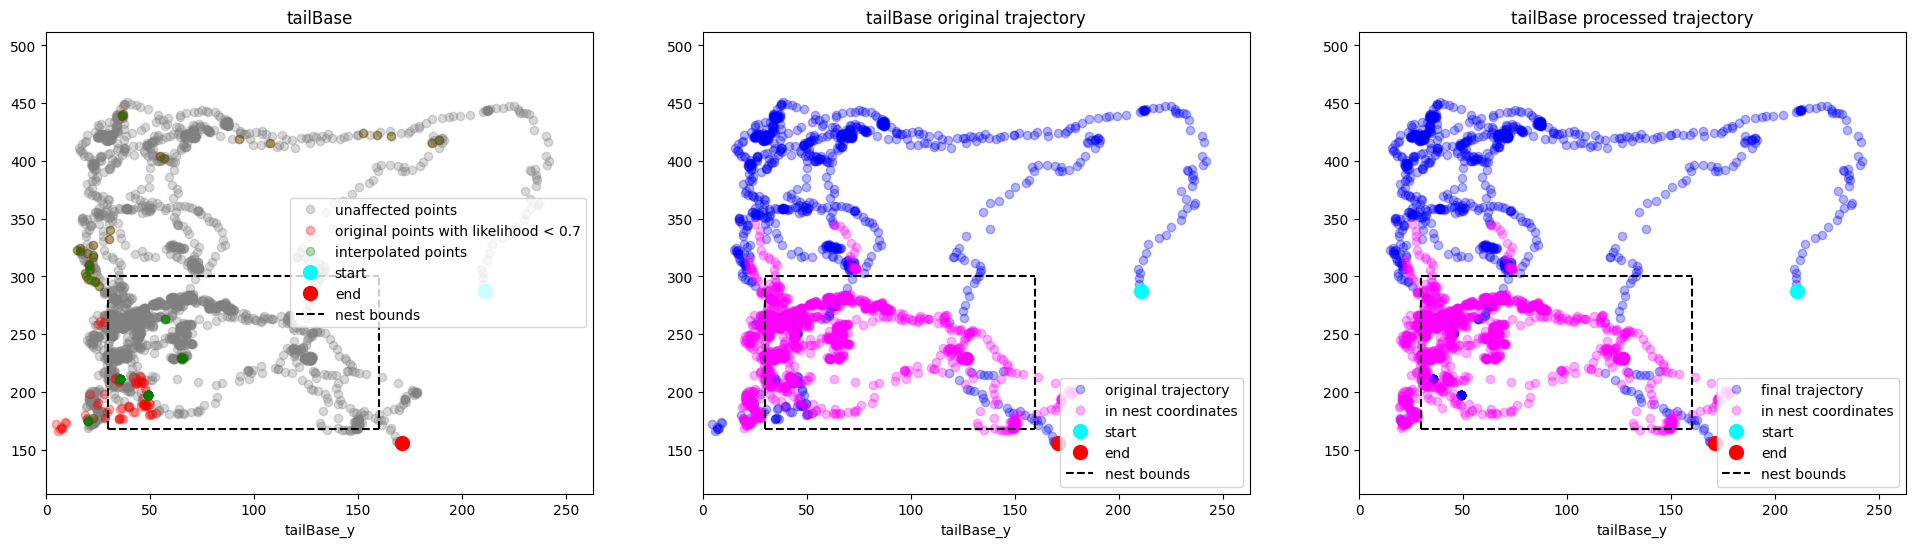

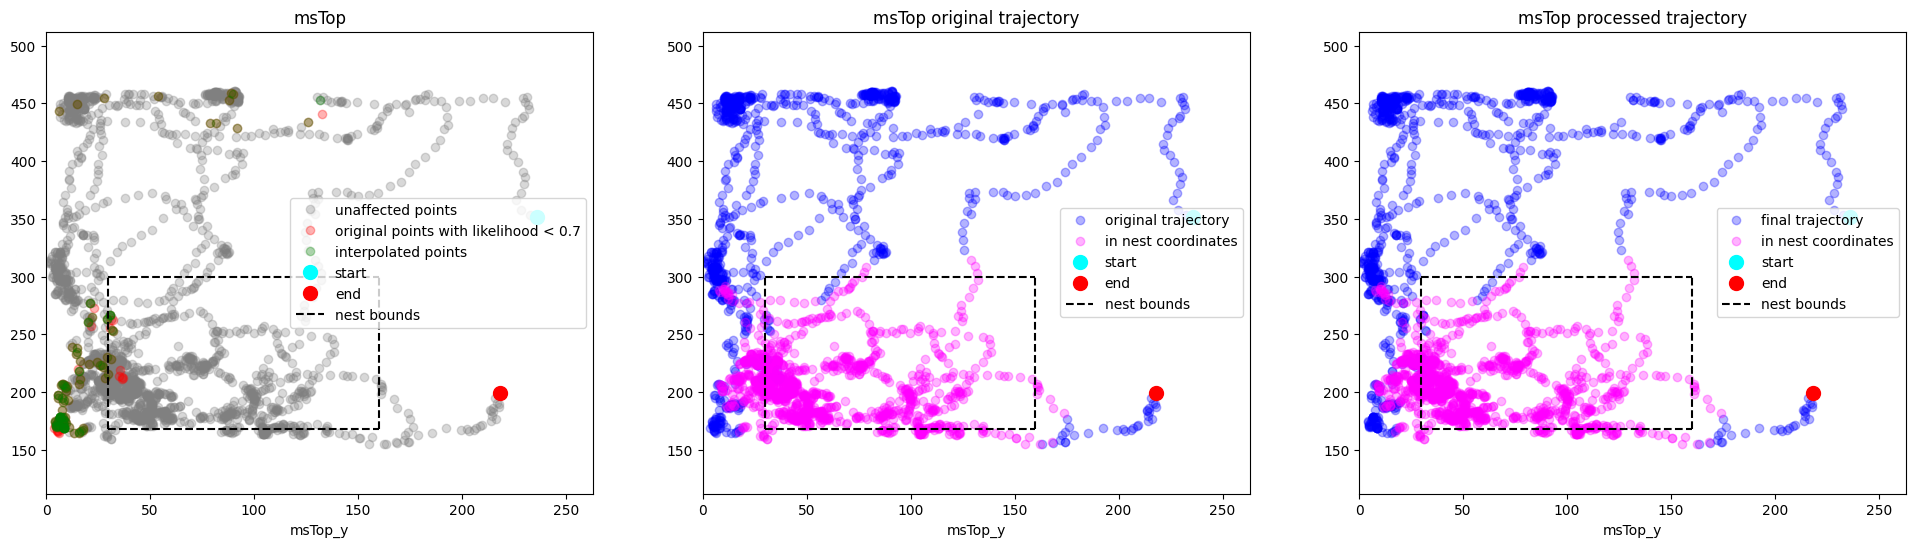

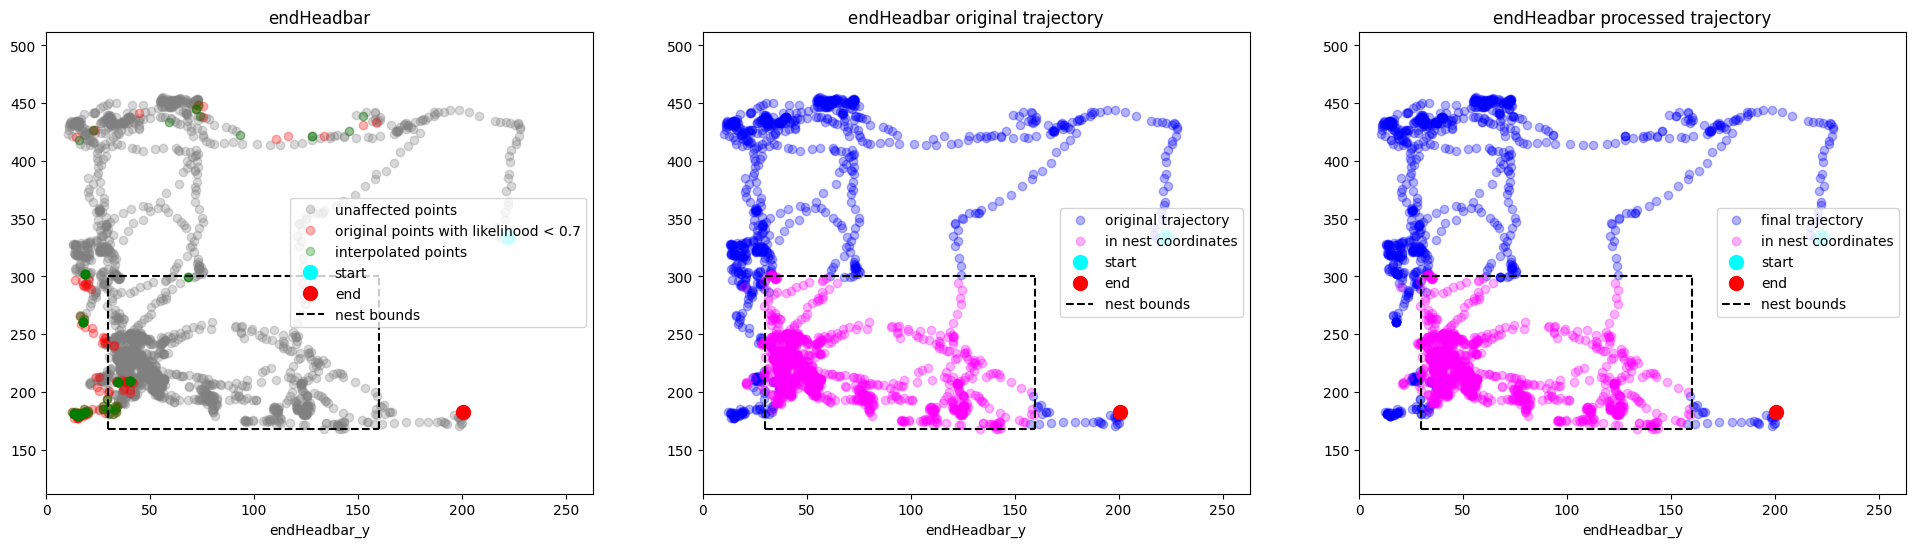

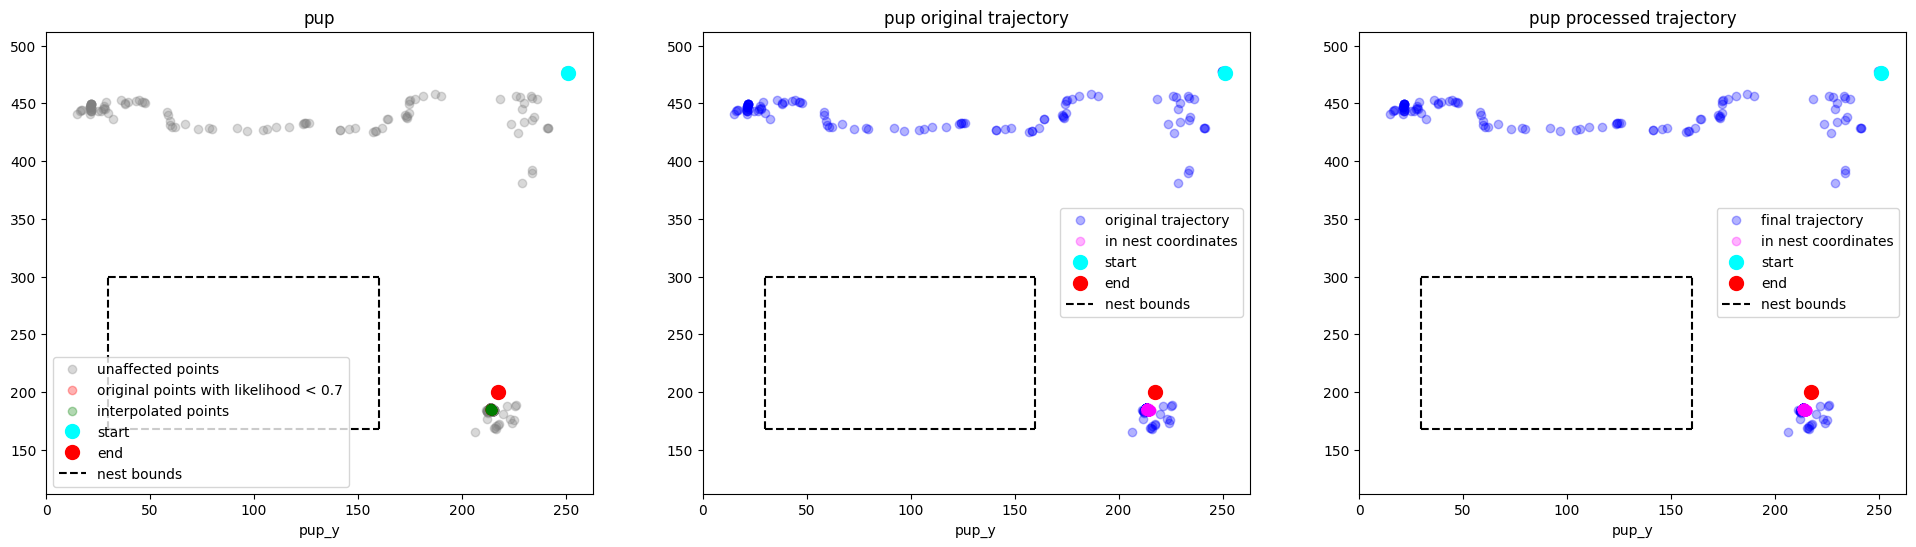

In [18]:
##### Select trial and experiment data #####
threshold = 0.7
BF.likelihood_threshold = threshold
dict_body_parts_to_coords = { k:v for k,v in BF.DLC_cols.items() if k not in ["mouse_position", "head_position", "centerNest"]}
day = "d1"
n = 3 # pick n in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
data = DL.get_data_for_experiment(mouse_id = "MBI5335RR", day = day)
df_DLC = data['Behavior']['df_dlc']
df_summary = data['Behavior']['df_summary']
trial_DLC, mask_trial = BF.extract_trial_from_DLC(df_DLC, df_summary, trial_num = n)
trial_DLC_processed = BF.process_trial(trial_DLC, trial_num = n, interpolate_low_likelihoods = True)

mask_nest = trial_DLC_processed["in_nest"]
nest_bounds = BF.config["nest_bounds"]

###### Start and end times in minutes from the time_seconds column #####
trial_start_time = trial_DLC["time_seconds"].iloc[0]
trial_end_time = trial_DLC["time_seconds"].iloc[-1]
print(f"Trial {n} started at {trial_start_time} and ended at {trial_end_time}")
print(f"Trial {n} started at {datetime.timedelta(seconds=trial_start_time)} and ended at {datetime.timedelta(seconds=trial_end_time)}")


for body_part in dict_body_parts_to_coords.keys():

    if type(dict_body_parts_to_coords[body_part]) == dict and "likelihood" in dict_body_parts_to_coords[body_part]:
        
        mask_interpolated =(trial_DLC_processed[BF.DLC_cols["mouse_position"]["likelihood"]] < threshold) & (~mask_nest)

        # create fig
        fig, ax = plt.subplots(1, 3, figsize=(24, 6))

        ##### ---- Plot 1:
        # - visualize original points with high likelihood
        trial_DLC.loc[~mask_interpolated].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                                       style='o', ax=ax[0], xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'grey', alpha = 0.3, label = "unaffected points")
        # - visualize low likelihood points in red
        trial_DLC.loc[mask_interpolated].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                                       style='o', ax=ax[0], xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'red', alpha = 0.3, label = f"original points with likelihood < {threshold}")
        # - visualize interpolated points in green
        trial_DLC_processed.loc[mask_interpolated].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                                       style='o', ax=ax[0], xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'green', alpha = 0.3, label = "interpolated points")
        
        #### ----- Plot 2 plot original trajectory
        trial_DLC[~mask_nest].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                             style='o', ax=ax[1], xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'blue', alpha = 0.3, label = "original trajectory")
        # - plot in nest coordinates
        trial_DLC[mask_nest].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                           style='o', ax=ax[1], xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'magenta', alpha = 0.3, label = "in nest coordinates")
        

        #### ----- Plot 3:  plot transformed/final trajectory
        trial_DLC_processed[~mask_nest].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                           style='o', ax=ax[2], xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'blue', alpha = 0.3, label = "final trajectory")
        # - plot in nest coordinates
        trial_DLC_processed[mask_nest].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                           style='o', ax=ax[2], xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'magenta', alpha = 0.3, label = "in nest coordinates")
        

        # mark the first point of the trajectory as a green dot, markersize = 10, label = "start"
        ax[0].plot(trial_DLC[dict_body_parts_to_coords[body_part]["y"]].iloc[0], trial_DLC[dict_body_parts_to_coords[body_part]["x"]].iloc[0], 'o', color = 'cyan', markersize = 10, label = "start")
        ax[1].plot(trial_DLC[dict_body_parts_to_coords[body_part]["y"]].iloc[0], trial_DLC[dict_body_parts_to_coords[body_part]["x"]].iloc[0], 'o', color = 'cyan', markersize = 10, label = "start")
        ax[2].plot(trial_DLC_processed[dict_body_parts_to_coords[body_part]["y"]].iloc[0], trial_DLC_processed[dict_body_parts_to_coords[body_part]["x"]].iloc[0], 'o', color = 'cyan', markersize = 10, label = "start")

        # mark the last point of the trajectory as a red dot, markersize = 10, label = "end"
        ax[0].plot(trial_DLC[dict_body_parts_to_coords[body_part]["y"]].iloc[-1], trial_DLC[dict_body_parts_to_coords[body_part]["x"]].iloc[-1], 'o', color = 'orange', markersize = 10, label = "end")
        ax[1].plot(trial_DLC[dict_body_parts_to_coords[body_part]["y"]].iloc[-1], trial_DLC[dict_body_parts_to_coords[body_part]["x"]].iloc[-1], 'o', color = 'orange', markersize = 10, label = "end")
        ax[2].plot(trial_DLC_processed[dict_body_parts_to_coords[body_part]["y"]].iloc[-1], trial_DLC_processed[dict_body_parts_to_coords[body_part]["x"]].iloc[-1], 'o', color = 'orange', markersize = 10, label = "end")
        
        # set title of body part as title of the plot
        ax[0].set_title(body_part)
        ax[1].set_title(body_part+ " original trajectory")
        ax[2].set_title(body_part+ " processed trajectory")

        # plot legend

        for i in range(3):
            # plot nest bounds
            ax[i].plot([nest_bounds["ymin"], nest_bounds["ymax"]], [nest_bounds["xmin"], nest_bounds["xmin"]], 'k--')
            ax[i].plot([nest_bounds["ymin"], nest_bounds["ymax"]], [nest_bounds["xmax"], nest_bounds["xmax"]], 'k--')
            ax[i].plot([nest_bounds["ymin"], nest_bounds["ymin"]], [nest_bounds["xmin"], nest_bounds["xmax"]], 'k--')
            ax[i].plot([nest_bounds["ymax"], nest_bounds["ymax"]], [nest_bounds["xmin"], nest_bounds["xmax"]], 'k--', label = "nest bounds")
            # plot legend
            ax[i].legend()





### Computing Base Parameters ###

In [19]:
trial_1_DLC, mask_trial = BF.extract_trial_from_DLC(df_DLC, df_summary, trial_num = 3)
trial_1_DLC = BF.process_trial(trial_1_DLC, trial_num = 3, interpolate_low_likelihoods = True)
mask = (trial_1_DLC["in_nest"] == False)

----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup


Speed

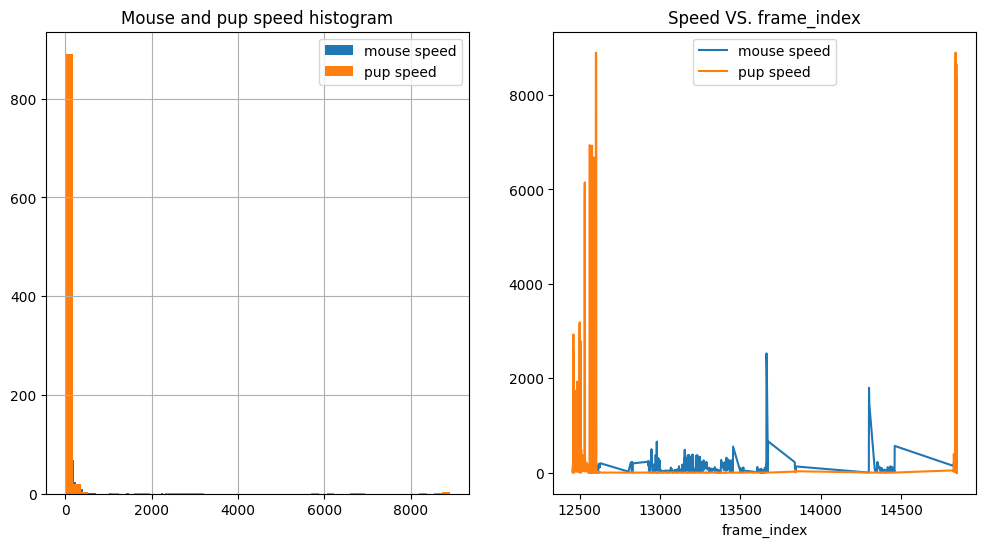

In [20]:
mouse_speed_col = BF.DLC_behaviour_cols["mouse_speed"]
pup_speed_col = BF.DLC_behaviour_cols["pup_speed"]

# create a grid of 2 histogram plots one for mouse speed and one for pup speed
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# histogram of speed

trial_1_DLC[mask][mouse_speed_col].hist(bins=50, ax=ax[0], label = 'mouse speed')
trial_1_DLC[mask][pup_speed_col].hist(bins=50, ax=ax[0], label = 'pup speed')
ax[0].set_title('Mouse and pup speed histogram')  # set title
ax[0].legend()  # show legend

# histogram of speed
trial_1_DLC[mask].plot(x='frame_index', y=mouse_speed_col, ax=ax[1], label = 'mouse speed')
trial_1_DLC[mask].plot(x='frame_index', y=pup_speed_col, ax=ax[1], label = 'pup speed')

ax[1].set_title('Speed VS. frame_index')  # set title
ax[1].legend()  # show legend

Distance to pup

Text(0.5, 0, 'Distance (px)')

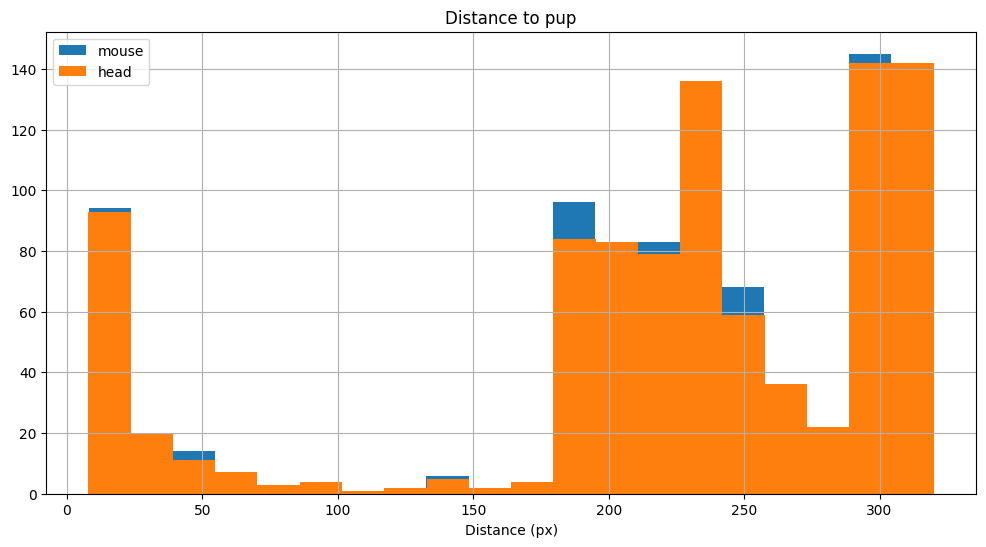

In [21]:
distance_mouse_to_pup = 'distance_mouse_to_pup'
distance_head_to_pup = 'distance_head_to_pup'
head_x_col, head_y_col = 'endHeadbar_x','endHeadbar_y'

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

trial_1_DLC[mask][distance_mouse_to_pup].hist(bins=20, ax=ax, label = 'mouse')
trial_1_DLC[mask][distance_head_to_pup].hist(bins=20, ax=ax, label = 'head')

ax.legend()

ax.set_title('Distance to pup')  # set title
ax.set_xlabel('Distance (px)')  # set x label

Head angle to pup

Text(0.5, 0, 'Angle (degrees)')

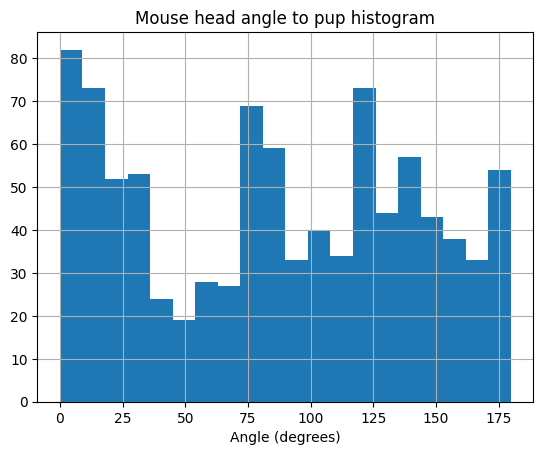

In [22]:
head_angle_to_pup_col = 'head_angle_to_pup_degrees'

trial_1_DLC[mask][head_angle_to_pup_col].hist(bins=20)
# set title
plt.title('Mouse head angle to pup histogram')
plt.xlabel('Angle (degrees)')  # set x-axis label

Visualize head angle to pup

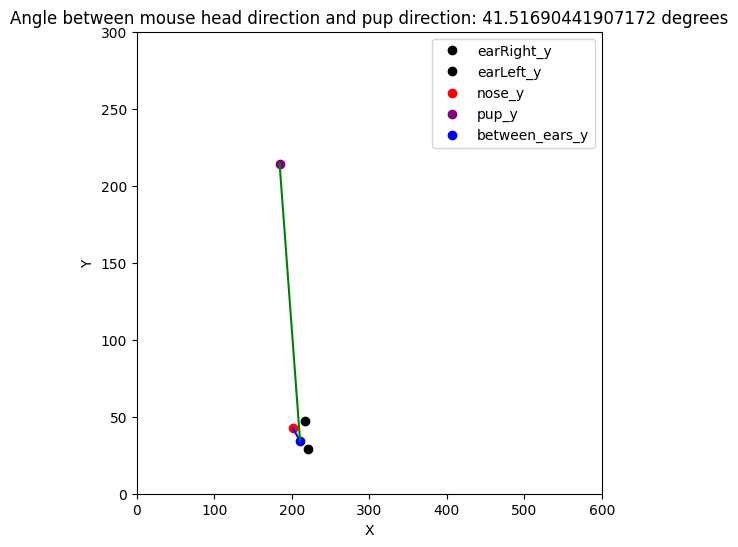

In [23]:
trial_1_DLC = BF.compute_head_angle_to_pup(trial_1_DLC, add_vector_columns=True)
plot_mouse_angle_to_pup(trial_1_DLC, ylim = 300 , xlim = 600)

#### Process full file (df_DLC) ####

In [24]:
df_DLC, df_summary = DL.get_data_for_experiment(mouse_id = "MBI5335RR", day = "d1")['Behavior'].values()

BF = BehaviourFeatureExtractor("config.json")
df_DLC_updated, trials_dict = BF.process_DLC(df_DLC, df_summary)

----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance t

In [25]:
df_DLC_updated.head(3)

frame_index  time_seconds     msTop_x    msTop_y  msTop_likelihood  \
151          151      5.033333  170.865509  89.811813          0.961542   
152          152      5.066667  170.884583  89.919662          0.960909   
153          153      5.100000  170.883240  90.323051          0.961621   

     endHeadbar_x  endHeadbar_y  endHeadbar_likelihood  earRight_x  \
151    190.735977     79.387955               0.943847  174.400299   
152    190.975998     79.499725               0.941302  174.574753   
153    191.376846     80.730232               0.936073  174.205078   

     earRight_y  ...      head_x     head_y  head_likelihood  pup_speed_px/s  \
151   80.521759  ...  185.848581  83.808566         0.907408             NaN   
152   80.326324  ...  185.651572  83.932812         0.905407             NaN   
153   80.630722  ...  185.266666  83.087607         0.895341             NaN   

     mouse_speed_px/s  distance_mouse_to_pup  distance_head_to_pup  \
151               NaN                    NaN                   NaN   
152               NaN                    NaN                   NaN   
153               NaN                    NaN                   NaN   

     head_angle_to_pup_degrees  in_nest  TrialNum  
151                        NaN     True       NaN  
152                        NaN     True       NaN  
153                        NaN     True       NaN  

[3 rows x 39 columns]

In [26]:
print("Elements of trials_dict:", trials_dict.keys())
trials_dict[1].head(3)

Elements of trials_dict: dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


frame_index  time_seconds     msTop_x    msTop_y  msTop_likelihood  \
11072        11072    369.066667  211.098618  66.026276          0.262119   
11073        11073    369.100000  203.101562  44.883198          0.139015   
11074        11074    369.133333  213.183609  66.150902          0.735463   

       endHeadbar_x  endHeadbar_y  endHeadbar_likelihood  earRight_x  \
11072    194.405746     59.853741               0.227935  185.651154   
11073    197.106476     60.143154               0.255601  202.642029   
11074    200.254944     52.229858               0.362945  206.455994   

       earRight_y  ...      head_x     head_y  head_likelihood  \
11072   50.854977  ...  190.367307  47.329676         0.267444   
11073   74.405647  ...  196.253473  56.367642         0.264922   
11074   69.558716  ...  205.817728  59.679120         0.426715   

       pup_speed_px/s  mouse_speed_px/s  distance_mouse_to_pup  \
11072        2.601532        278.424087             349.082791   
11073        0.020415        258.487665             340.386672   
11074        0.004578        293.783507             332.604115   

       distance_head_to_pup  head_angle_to_pup_degrees  in_nest  TrialNum  
11072            350.839027                 177.221608     True       NaN  
11073            340.862167                  47.468735     True       NaN  
11074            331.129988                  26.092726     True       NaN  

[3 rows x 39 columns]

## Detecting higher level behaviours ##

#### Approach ####

In [21]:
ms_id = "VBQ0261L"
d = "d4"
trial_num =  1#  pick n in 1 ... 10

df_DLC = experiment_data[ms_id][d]["Behavior"]["df_dlc"].copy()
df_Avi = experiment_data[ms_id][d]["Avisoft"]["df"].copy()
df_summary = experiment_data[ms_id][d]["Behavior"]["df_summary"].copy()

trials = experiment_data[ms_id][d]["trials"].copy()
trial_DLC = trials[trial_num]["dlc_data"].copy()

In [22]:
trial_pickup_time = df_summary.loc[df_summary[BF.DLC_summary_cols["trial_num"]] == trial_num, BF.DLC_summary_cols["mouse_first_pick_up"]].values[0]
trial_start_frame_index = trial_DLC["frame_index"].iloc[0]
trial_start_time = trial_DLC["time_seconds"].iloc[0]
trial_pickup_time_minutes = f"{str(trial_pickup_time//60)}m:{int(trial_pickup_time%60)}s"

print("Interesting time point, mouse first picks up pup:", trial_pickup_time, "seconds", trial_pickup_time_minutes)
print(f"Trial {trial_num} starts at frame index {trial_start_frame_index} and time {trial_start_time}")

Interesting time point, mouse first picks up pup: 420.513 seconds 7.0m:0s
Trial 1 starts at frame index 12343 and time 411.43333333333334


In [28]:
pre_event_window_size_time = 10 # secs
event_time_point = trial_pickup_time # secs

# conversion to frames
event_time_point_frame = convert_seconds_to_frame(event_time_point, BF.frame_rate)
pre_event_window_size_frames = convert_seconds_to_frame(pre_event_window_size_time, BF.frame_rate) # convert to frames 

# if window is too big, spills over trial start, raise error
# compare len of df[start_time_frame - pre_event_window_size_frames  :start_time_frame]

start_frame_index = event_time_point_frame - pre_event_window_size_frames
print("Start frame index:", start_frame_index)
print("Start of trial frame index:", trial_start_frame_index)

if start_frame_index < trial_start_frame_index:
    warnings.warn(f"Window is too big, spills over trial start, resetting window size to {trial_start_frame_index - start_frame_index}")
    pre_event_window_size_frames = trial_start_frame_index - start_frame_index

# compute derivatives for columns in "DLC_behaviour_columns" in the BF over window,  ["mouse_speed", "distance_mouse_pup"]
window = trial_DLC.loc[start_frame_index:event_time_point_frame].copy()

# distance mouse to pup corner
pup_corner_bounds = BF.extract_pup_starting_position_bounds(df_summary, trial_num)
pup_center_x, pup_center_y = pup_corner_bounds["xmin"] + (pup_corner_bounds["xmax"] - pup_corner_bounds["xmin"]) / 2, pup_corner_bounds["ymin"] + (pup_corner_bounds["ymax"] - pup_corner_bounds["ymin"]) / 2
window["distance_mouse_pup_center"] = np.sqrt((window["mouse_x"] - pup_center_x)**2 + (window["mouse_y"] - pup_center_y)**2)
window["distance_head_pup_center"] = np.sqrt((window["head_x"] - pup_center_x)**2 + (window["head_y"] - pup_center_y)**2)


# compute derivatives wrt time_seconds for columns in "DLC_behaviour_columns" in the BF over window,  ["mouse_speed", "distance_mouse_pup"]
columns = [BF.DLC_behaviour_cols["mouse_speed"], "distance_mouse_pup_center", "distance_head_pup_center"]

# for each column in columns, convert to cm and then compute derivatives
px_cm_ratio = BF.config["pixels_to_cm_ratio"]
for col in columns:
    window[col+"_cm"] = window[col] / px_cm_ratio
    window[col+"_cm_deriv"] = np.gradient(window[col+"_cm"])
    #window[col+"_cm_deriv"] = (window[col+"_cm"].diff() / window["time_seconds"].diff()).fillna(0)

# smooth out the derivatives

kernel_size = 20
kernel = np.ones(kernel_size) / kernel_size
window["mouse_speed_px/s_cm_convolved"] = np.convolve(window["mouse_speed_px/s_cm"], kernel, mode='same')
window["mouse_speed_px/s_cm_deriv_convolved"] = np.gradient(window["mouse_speed_px/s_cm_convolved"])
window["distance_mouse_pup_center_cm_deriv_convolved"] = np.convolve(window["distance_mouse_pup_center_cm_deriv"], kernel, mode='same')

mask_approach = (window["distance_mouse_pup_center_cm_deriv_convolved"] < -0.1) & (window["head_angle_to_pup_degrees"] < 90)
mask_crouching = (window["distance_mouse_pup_center_cm"] < 5) & (window["mouse_speed_px/s_cm_convolved"] < 5)
mask_caring = (window["distance_head_pup_center_cm"] < 5) & (window["mouse_speed_px/s_cm_convolved"] < 5)

window["approach"] = mask_approach
window["crouching"] = mask_crouching
window["caring"] = mask_caring

# print count of approach and crouching
print("Approach count:", window["approach"].sum())
print("Crouching count:", window["crouching"].sum())
print("Caring count:", window["caring"].sum())

window[["time_seconds", "approach", "crouching", "caring",
       "mouse_speed_px/s_cm_convolved", "distance_mouse_pup_center_cm", "mouse_speed_px/s_cm_deriv_convolved",
        "distance_mouse_pup_center_cm_deriv_convolved", 
       "head_angle_to_pup_degrees"]].iloc[-10:]

Start frame index: 12315
Start of trial frame index: 12343
Approach count: 69
Crouching count: 29
Caring count: 39


time_seconds  approach  crouching  caring  \
12606    420.200000     False       True    True   
12607    420.233333     False       True    True   
12608    420.266667     False       True    True   
12609    420.300000     False      False    True   
12610    420.333333     False      False    True   
12611    420.366667     False      False    True   
12612    420.400000     False      False    True   
12613    420.433333     False      False    True   
12614    420.466667     False      False    True   
12615    420.500000     False      False   False   

       mouse_speed_px/s_cm_convolved  distance_mouse_pup_center_cm  \
12606                       3.506756                      4.683143   
12607                       3.388189                      4.839093   
12608                       3.327002                      4.982558   
12609                       3.315501                      5.035039   
12610                       3.216739                      5.104772   
12611                       3.195435                      5.178857   
12612                       3.011032                      5.426569   
12613                       2.913116                      5.578847   
12614                       2.751910                      5.830202   
12615                       2.560691                      6.070644   

       mouse_speed_px/s_cm_deriv_convolved  \
12606                             0.008419   
12607                            -0.089877   
12608                            -0.036344   
12609                            -0.055132   
12610                            -0.060033   
12611                            -0.102854   
12612                            -0.141159   
12613                            -0.129561   
12614                            -0.176213   
12615                            -0.191218   

       distance_mouse_pup_center_cm_deriv_convolved  head_angle_to_pup_degrees  
12606                                      0.097688                  35.772272  
12607                                      0.098265                  32.433371  
12608                                      0.100292                  32.267326  
12609                                      0.100817                  29.376718  
12610                                      0.099589                  25.301622  
12611                                      0.098656                  22.717212  
12612                                      0.095718                   1.401139  
12613                                      0.091160                   4.700962  
12614                                      0.087139                   7.381146  
12615                                      0.081541                  14.646751

Text(0.5, 1.0, 'Distance to pup and distance derivative')

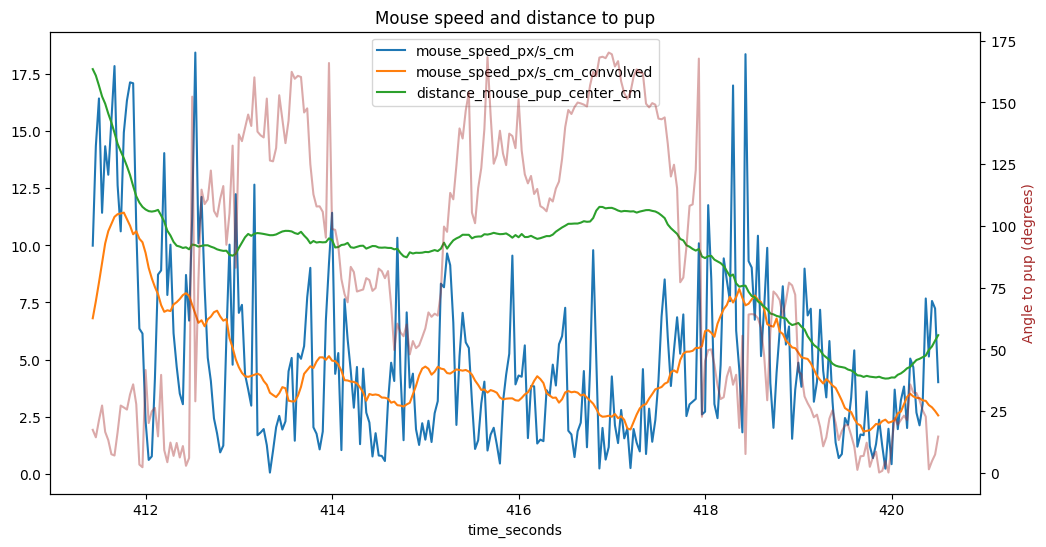

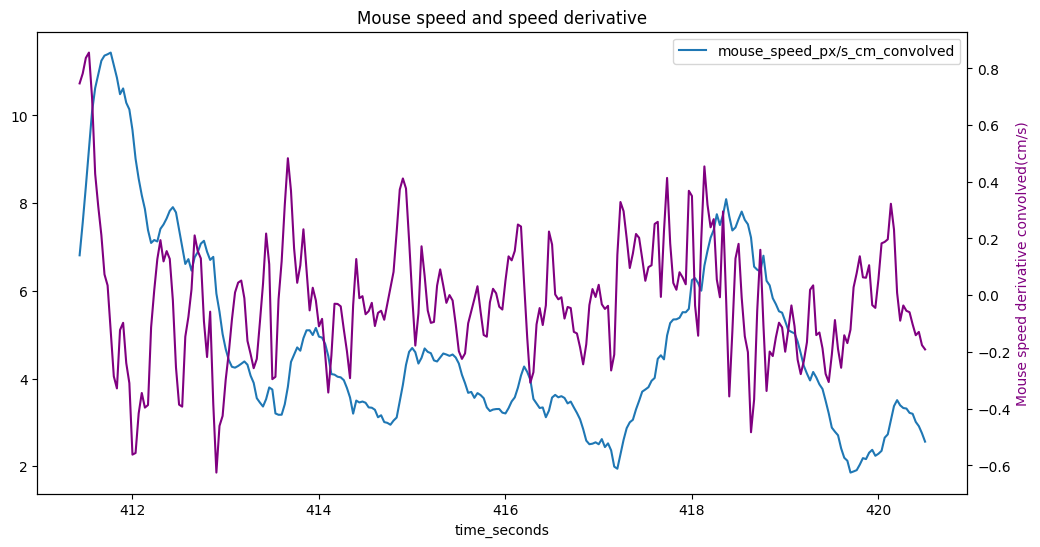

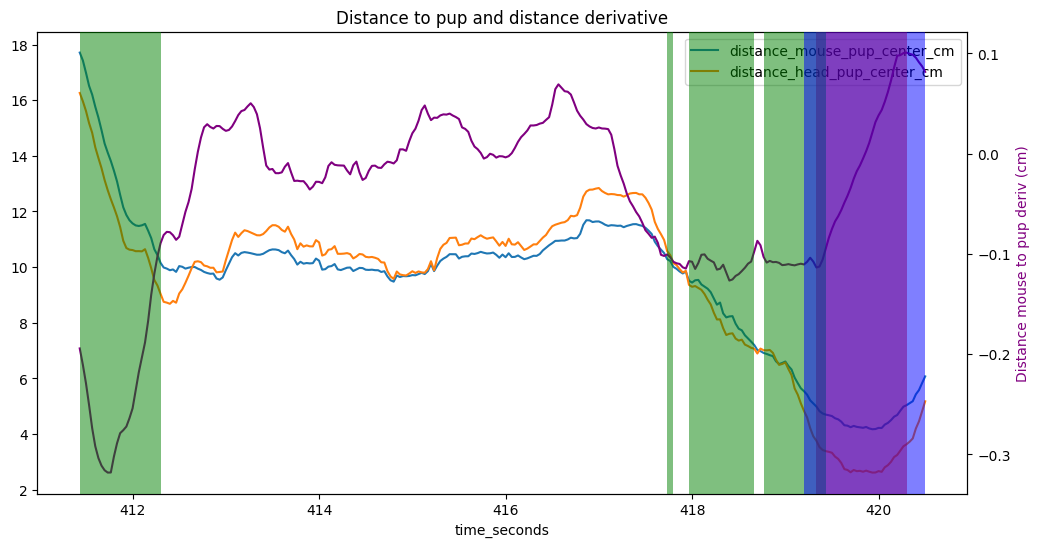

In [29]:
# add another axis
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

##### Plot 1: original data
window.plot(x="time_seconds", y=["mouse_speed_px/s_cm", "mouse_speed_px/s_cm_convolved",
                             "distance_mouse_pup_center_cm"], ax = ax, title = "Original data")
ax2 = ax.twinx()
ax2.plot(window["time_seconds"], window["head_angle_to_pup_degrees"],
         color= "brown",
         label = "head angle to pup", alpha = 0.4)
# set y axis name
ax2.set_ylabel("Angle to pup (degrees)", color = "brown")
# set title
ax.set_title("Mouse speed and distance to pup")


##### Plot 2: mouse_speed_px + derivative
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
window.plot(x="time_seconds", y=["mouse_speed_px/s_cm_convolved"], ax = ax)
ax2 = ax.twinx()
ax2.plot(window["time_seconds"],
         window["mouse_speed_px/s_cm_deriv_convolved"],
         color="purple")
# set y axis name
ax2.set_ylabel("Mouse speed derivative convolved(cm/s)", color = "purple")
# set title
ax.set_title("Mouse speed and speed derivative")



##### Plot 3: mouse_pup_distance + derivative
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
window.plot(x="time_seconds", y=["distance_mouse_pup_center_cm", "distance_head_pup_center_cm"], ax = ax, zorder = 10)
ax2 = ax.twinx()
ax2.plot(window["time_seconds"],
         window["distance_mouse_pup_center_cm_deriv_convolved"],
         color="purple")
# add a shaded rectangle for values of crouching that is True
# for every value of crouching that is True
for i in range(len(window["crouching"])):
    if window["crouching"].iloc[i]:
        # add a vertical shaded rectangle at the timepoint
        ax2.axvspan(window["time_seconds"].iloc[i],
                    window["time_seconds"].iloc[i]+1/30,
                    facecolor='red', alpha=0.5, zorder = 5)
# add a shaded rectangle to show when the mouse is approaching
for i in range(len(window["approach"])):
    if window["approach"].iloc[i]:
        ax2.axvspan(window["time_seconds"].iloc[i],
                    window["time_seconds"].iloc[i+1],
                    facecolor='green', alpha=0.5, zorder = 5)
        
for i in range(len(window["caring"])):
    if window["caring"].iloc[i]:
        ax2.axvspan(window["time_seconds"].iloc[i],
                    window["time_seconds"].iloc[i]+1/30,
                    facecolor='blue', alpha=0.5, zorder = 5)
# set y axis name
ax2.set_ylabel("Distance mouse to pup deriv (cm)", color = "purple")
# set title
ax.set_title("Distance to pup and distance derivative")


# # second axis
# ax2.plot(window["time_seconds"], window["head_angle_to_pup_degrees"], color="red")

# third axis derivatives
# ax3 = ax.twinx()
# ax3.plot(window["time_seconds"], window["mouse_speed_px/s_cm_deriv"])

## Pup position tracking ##

### Data loading ###

In [5]:
ideal_cases = [("VBQ0261L", "d4", 2), ("VBQ0261L", "d3", 9), ("VBQ0261L", "d3", 3), ("MBI5335RR", "d3", 7)]
noisy_cases = [("MBI5335RR", "d6", 10), ("MBI5335RR", "d5", 3), ("MBI5335RR", "d6", 8)]
no_pup_cases = [("VBQ0261L", "d3", 10)]
double_locations = [("MBI5335RR", "d5", 9)]
few_point_cases = [("VBQ0261L", "d1", 5), ("VBQ0261L", "d1", 7), ("VBQ0261L", "d1", 10)]

In [6]:
data_dir = "data"
DL = DataLoader(data_dir, path_to_config_file="config.json")
BF = BehaviourFeatureExtractor("config.json")
VF = VocalFeatureExtractor("config.json")

In [7]:
all_cases = ideal_cases + noisy_cases + no_pup_cases + double_locations + few_point_cases
experiment_data = {}

for case in all_cases:
    ms_id, d, trial_num = case
    if ms_id not in experiment_data:
        experiment_data[ms_id] = {}
    
    if d not in experiment_data[ms_id]:
        experiment_data[ms_id][d] = {}
    else:
        continue
    
    # Load data
    data = DL.get_data_for_experiment(mouse_id = ms_id,
                                        day = d)
    if data is None:
        print("Data not found for mouse", ms_id, "on day", d)
        continue
    
    experiment_data[ms_id][d] = data

    df_DLC = experiment_data[ms_id][d]["Behavior"]["df_dlc"].copy()
    df_Avi = experiment_data[ms_id][d]["Avisoft"]["df"].copy()
    df_summary = experiment_data[ms_id][d]["Behavior"]["df_summary"].copy()

    # align USV data to DLC data
    df_DLC_processed, _ = BF.process_DLC(df_DLC.copy(), df_summary)
    trials, df_DLC, df_USV = VF.process_USV(df_Avi, df_summary, df_DLC_processed)
    experiment_data[ms_id][d]["trials"] =  trials

----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance t

### Data visualization ###

In [50]:
def get_pick_up_time(df_summary, trial_num, BF):
        """
        Get the time when mouse first picked up pup for a given trial.
        
        Parameters:
        -----------
        df_summary : pandas DataFrame
            DataFrame containing summary data
        trial_num : int
            Trial number
        BF : object
            BehaviorFinder object containing configuration parameters
            
        Returns:
        --------
        float
            Time in seconds when mouse first picked up pup
        """
        trial_num_col = BF.config["DLC_summary_columns"]["trial_num"]
        pick_up_time_col = BF.config["DLC_summary_columns"]["mouse_first_pick_up"]
        return df_summary.loc[df_summary[trial_num_col] == trial_num, pick_up_time_col].values[0]


def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)


def visualize_pup_trajectory(mouse_id, day, trial_num,
                            df_summary, df_dlc, 
                            path_dir, 
                            BF_instance,
                            BF_config,
                            cmap = "plasma",
                            pup_dict = None,
                            skip_average = False,
                            trial_dlc = None,
                            threshold_likelihood_pup = 0.7): 
    if trial_dlc is None:
        trial_dlc, _ = BF_instance.extract_trial_from_DLC(df_dlc, df_summary, trial_num = trial_num)

    trial_success = df_summary.loc[df_summary[BF_config["DLC_summary_columns"]["trial_num"]] == trial_num,
                                    BF_config["DLC_summary_columns"]["trial_success"]].values[0]
    pup_disp_pos = df_summary.loc[df_summary[BF_config["DLC_summary_columns"]["trial_num"]] == trial_num,
                                    BF_config["DLC_summary_columns"]["pup_displacement_position"]].values[0]
    pup_position_bounds = BF_instance.extract_pup_starting_position_bounds(df_summary, trial_num)

    fig, ax = plt.subplots(figsize = (10,10))

    if not skip_average:
        ##### plot the average of all ABC
        pup_average_likelihood = np.mean([trial_dlc[BF_config["DLC_columns"]["pupA"]["likelihood"]],
                                        trial_dlc[BF_config["DLC_columns"]["pupB"]["likelihood"]],
                                        trial_dlc[BF_config["DLC_columns"]["pupC"]["likelihood"]]], axis = 0)
        pup_average_y = np.mean([trial_dlc[BF_config["DLC_columns"]["pupA"]["y"]], 
                                trial_dlc[BF_config["DLC_columns"]["pupB"]["y"]],
                                trial_dlc[BF_config["DLC_columns"]["pupC"]["y"]]], axis = 0)
        pup_average_x = np.mean([trial_dlc[BF_config["DLC_columns"]["pupA"]["x"]],
                                trial_dlc[BF_config["DLC_columns"]["pupB"]["x"]],
                                trial_dlc[BF_config["DLC_columns"]["pupC"]["x"]]], axis = 0)

        trial_dlc["pup_x"] = pup_average_x
        trial_dlc["pup_y"] = pup_average_y
        trial_dlc["pup_likelihood"] = pup_average_likelihood
    
    #color = np.linspace(0, 1, trial_dlc.shape[0])
    color = (trial_dlc["time_seconds"] - trial_dlc["time_seconds"].iloc[0])

    # plot the time color on the trajectory
    lines = colored_line(trial_dlc["pup_y"], trial_dlc["pup_x"], color, ax, linewidth=2, zorder = 5, cmap=cmap, alpha = 0.7)
    cbar = fig.colorbar(lines, label="Time (s)")  # store colorbar reference

    # Add lines for each cluster's start/end times
    if pup_dict:
        # Get colorbar axis
        cax = cbar.ax
        
        # Calculate normalized positions for the lines (between 0 and 1)
        time_min = trial_dlc["time_seconds"].min()
        time_max = trial_dlc["time_seconds"].max()
        time_range = time_max - time_min
        
        # Create different colors for different clusters
        colors = ['red', 'blue', 'green', 'orange', 'purple']  # extend if needed
        
        for i, (cluster_name, cluster_data) in enumerate(pup_dict.items()):
            start_time = cluster_data['start_time']
            end_time = cluster_data['end_time']
            
            # Convert times to normalized positions
            start_pos = start_time - time_min
            end_pos = end_time - time_min
            
            # Add horizontal lines at start and end times
            color = colors[i % len(colors)]
            cax.axhline(y=start_pos, color=color, linestyle='--', linewidth=1)
            cax.axhline(y=end_pos, color=color, linestyle='--', linewidth=1)
            
            # Add text labels
            cax.text(1.5, start_pos, f'{cluster_name} start', 
                    color=color, ha='left', va='center')
            cax.text(1.5, end_pos, f'{cluster_name} end',
                    color=color, ha='left', va='center')

    # only plot points > likelihood threshold
    mask = trial_dlc["pup_likelihood"] < threshold_likelihood_pup
    trial_dlc[~mask].plot(x = "pup_y", y = "pup_x",
                kind = "scatter",
                marker = "o",
                ax = ax,
                s = 30,
                alpha = 0.4,
                zorder = 7,
                color = "green", label = "pup_ABC")
    
    # add a red cross if likelihood is below threshold_likelihood_pup
    trial_dlc.loc[mask].plot(x = "pup_y",
                            y = "pup_x",
                            marker = "x",
                            kind = "scatter",
                            ax = ax,
                            alpha = 0.4,
                            s = 30,
                            color = "red",
                            zorder = 5,
                            label = f"pup_low_likelihood < {threshold_likelihood_pup}")
    
    trial_dlc.iloc[0:1].plot(x = "pup_y", y = "pup_x",
                        kind = "scatter",
                        marker = "*",
                        alpha = 1.,
                        s = 200,
                        edgecolors='black',
                        ax = ax,
                        color = "cyan", label = "start",zorder = 10)
    trial_dlc.iloc[-1:].plot(x = "pup_y", y = "pup_x",
                            kind = "scatter",
                            marker = "*",
                            alpha = 1.,
                            s = 200,
                            edgecolors='black',
                            ax = ax,
                            color = "green", label = "end", zorder = 10)
        
    # set x and y labels
    ax.set_xlabel("pup y")
    ax.set_ylabel("pup x")

    arena_bounds = BF_config["arena_bounds"]
    nest_bounds = BF_config["nest_bounds"]
        
    # set x and y limits
    ax.set_xlim([arena_bounds["ymin"], arena_bounds["ymax"]])
    ax.set_ylim([arena_bounds["xmin"], arena_bounds["xmax"]])
        
    # plot the arena
    ax.plot([nest_bounds["ymin"], nest_bounds["ymax"]], [nest_bounds["xmin"], nest_bounds["xmin"]], 'k--')
    ax.plot([nest_bounds["ymin"], nest_bounds["ymax"]], [nest_bounds["xmax"], nest_bounds["xmax"]], 'k--')
    ax.plot([nest_bounds["ymin"], nest_bounds["ymin"]], [nest_bounds["xmin"], nest_bounds["xmax"]], 'k--')
    ax.plot([nest_bounds["ymax"], nest_bounds["ymax"]], [nest_bounds["xmin"], nest_bounds["xmax"]], 'k--', label = "nest_bounds")

    # plot the pup position bounds
    ax.plot([pup_position_bounds["ymin"], pup_position_bounds["ymax"]], [pup_position_bounds["xmin"], pup_position_bounds["xmin"]], 'r--')
    ax.plot([pup_position_bounds["ymin"], pup_position_bounds["ymax"]], [pup_position_bounds["xmax"], pup_position_bounds["xmax"]], 'r--')
    ax.plot([pup_position_bounds["ymin"], pup_position_bounds["ymin"]], [pup_position_bounds["xmin"], pup_position_bounds["xmax"]], 'r--')
    ax.plot([pup_position_bounds["ymax"], pup_position_bounds["ymax"]], [pup_position_bounds["xmin"], pup_position_bounds["xmax"]], 'r--', label = "pup_position_bounds")

    ax.legend()

    def seconds_to_mmss(seconds):
        minutes = int(seconds // 60)
        remaining_seconds = int(seconds % 60)
        return f"{minutes:02d}:{remaining_seconds:02d}"
        
    start_time = seconds_to_mmss(trial_dlc['time_seconds'].iloc[0])
    pick_up_time = get_pick_up_time(df_summary, trial_num, BF_instance)
    if not np.isnan(pick_up_time):                                                       
        pick_up_time_s = seconds_to_mmss(pick_up_time)
    else:
        pick_up_time_s = pick_up_time

    title = f"Mouse id: {mouse_id}, Trial : {trial_num} Session : {day}, Success : {trial_success}, Start time: {start_time}, Pick-up time: {pick_up_time_s}"
    ax.set_title(title)
    
    if path_dir is not None:
        plt.savefig(f"{path_dir}/pup_trajectory_{mouse_id}_{day}_trial_{trial_num}.png")
    plt.show()


#### Original data ####

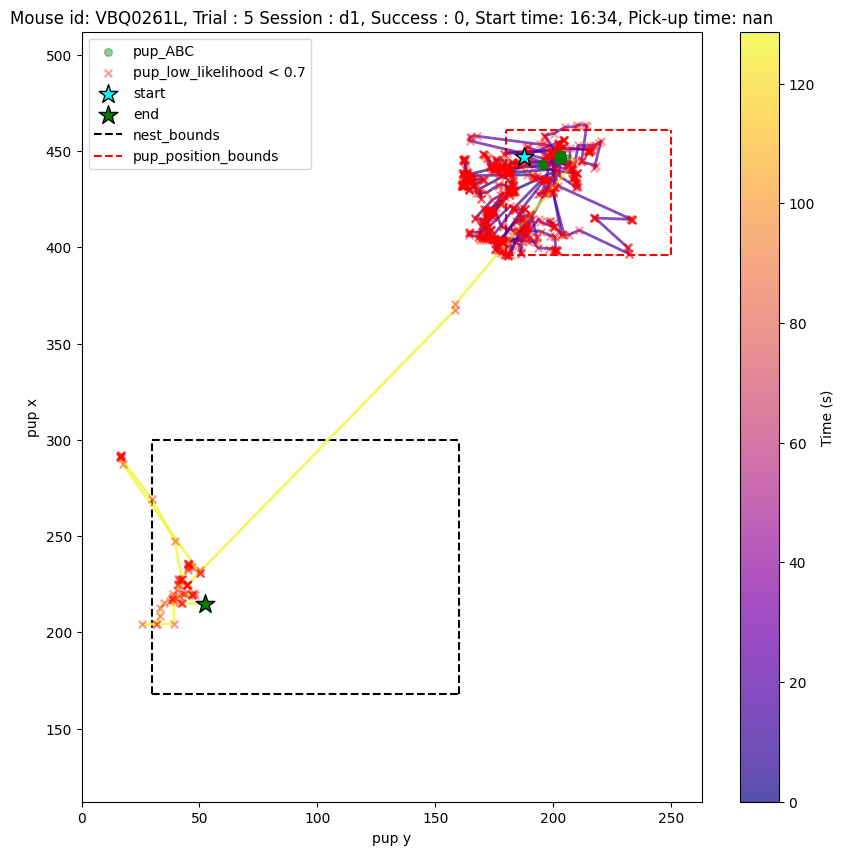

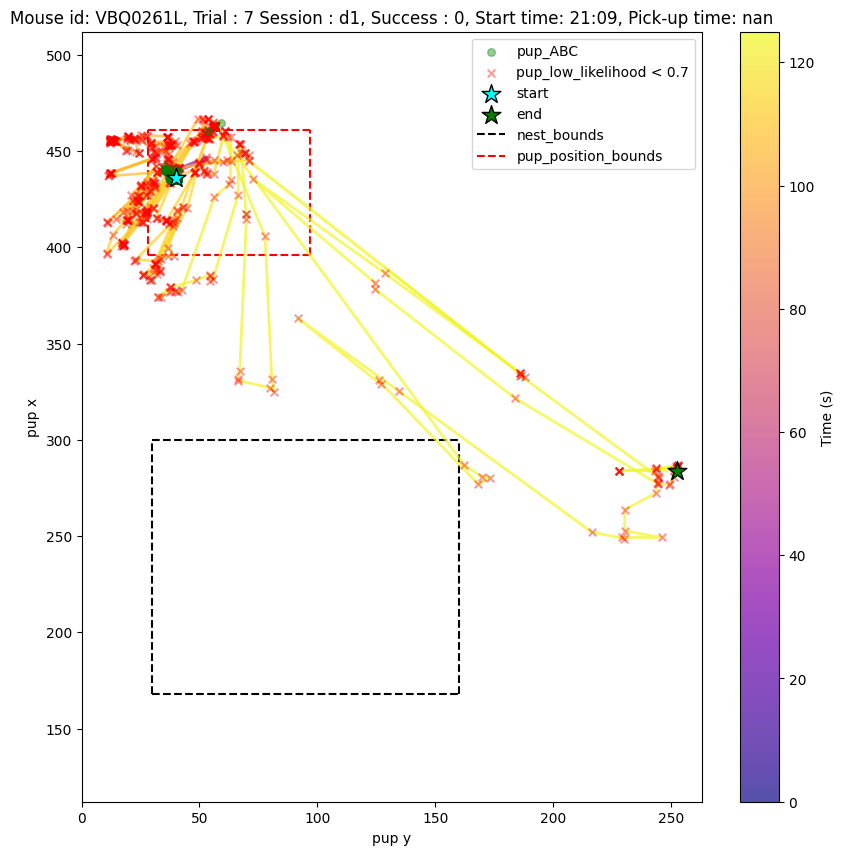

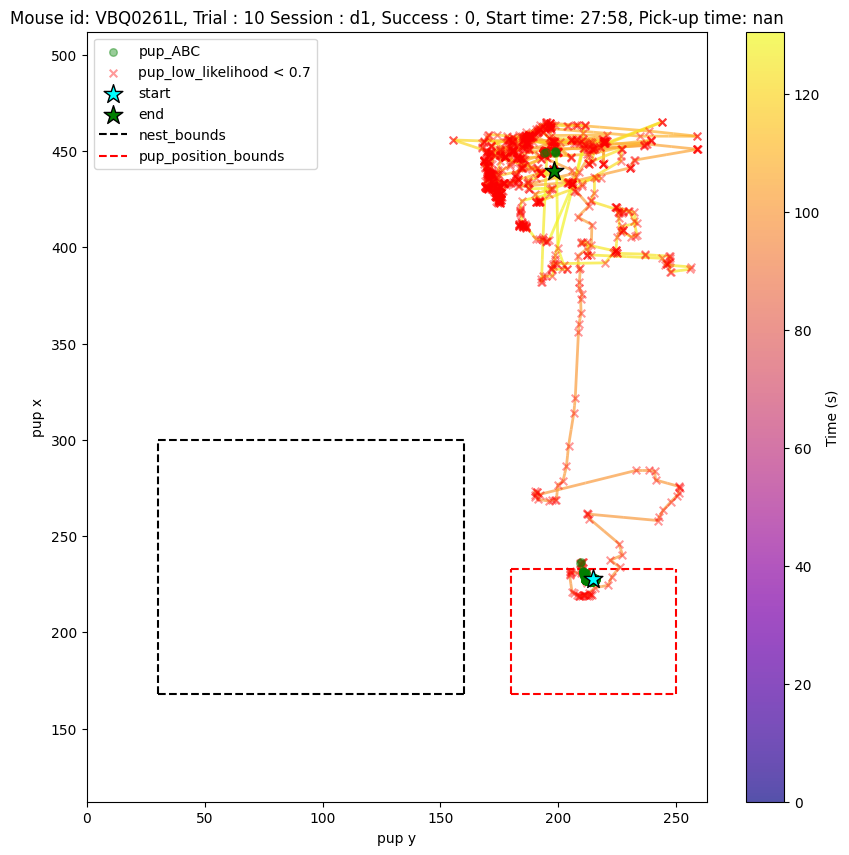

In [67]:
for case in few_point_cases:
    ms_id, d, trial_num = case
    red = Color("orange")
    colors = list(red.range_to(Color("purple"),3))

    visualize_pup_trajectory(mouse_id = ms_id, day = d, trial_num = trial_num, 
                            df_summary=experiment_data[ms_id][d]["Behavior"]["df_summary"], 
                            df_dlc=experiment_data[ms_id][d]["Behavior"]["df_dlc"],
                            path_dir = None, 
                            BF_instance = BF,
                            BF_config = BF.config,
                            threshold_likelihood_pup = 0.7)

#### Transformed data ####

In [56]:

def compute_distances_intra_coords(BF, trial_dlc, cols = ["pupA", "pupB", "pupC"]):
    # computing distances
    dAB = cols[0], cols[1]
    dAC = cols[0], cols[2]
    dBC = cols[1], cols[2]

    for distance in dAB, dAC, dBC:
        point1, point2 = distance
        trial_dlc = BF.compute_distance_to_pup(trial_dlc,
                                    x_col = BF.DLC_cols[point1]["x"], y_col = BF.DLC_cols[point1]["y"],
                                    pup_x_col = BF.DLC_cols[point2]["x"], pup_y_col = BF.DLC_cols[point2]["y"],
                                    distance_col = f'distance_{point1}_{point2}')
    
        # convert distances to cm
        trial_dlc[f'distance_{point1}_{point2}_cm'] = trial_dlc[f'distance_{point1}_{point2}'] / BF.config["pixels_to_cm_ratio"]
        
    return trial_dlc

def filter_speed_pup(BF, trial_dlc, 
                    pup_cols = ["pupA", "pupB", "pupC"],
                    threshold_speed_pup_cm = 5):
    # recompute pup speed
    for pup_col in pup_cols:
        trial_dlc = BF.compute_speed(trial_dlc, x_col = BF.DLC_cols[pup_col]["x"],
                                            y_col = BF.DLC_cols[pup_col]["y"],
                                            speed_col = f"{pup_col}_speed")
        # convert speed to cm
        trial_dlc[f"{pup_col}_speed_cm"] = trial_dlc[f"{pup_col}_speed"] / BF.config["pixels_to_cm_ratio"]

        # label likelihood 0 for points with speed > threshold_speed_pup_cm
        mask = (trial_dlc[f"{pup_col}_speed_cm"] > threshold_speed_pup_cm)
        initially_high_likelihood = (trial_dlc[f"{pup_col}_likelihood"] > 0.7) & mask

        print(f"Number of implausible speed measurements for {pup_col}: {mask.sum()}, initially high likelihood: {initially_high_likelihood.sum()}")
        trial_dlc.loc[mask, f"{pup_col}_likelihood"] = 0

    return trial_dlc

def filter_pick_up_constraint(BF, trial_dlc,
                            df_summary,
                            trial_num,
                            pup_cols = ["pupA", "pupB", "pupC"]):

    # get the pick up time
    pick_up_time = get_pick_up_time(df_summary, trial_num, BF_instance)

    # get pup displacement bounds
    pup_disp_bounds = BF.extract_pup_starting_position_bounds(df_summary, trial_num)

    # define the time window for the pup to stay in the initial position
    if pick_up_time is not None: # trial with pick up
        start_time = trial_dlc["time_seconds"].iloc[0]
        end_time = pick_up_time
    else: # failed trial
        start_time = trial_dlc["time_seconds"].iloc[0]
        end_time = trial_dlc["time_seconds"].iloc[-1]

    pre_pickup_times = (trial_dlc["time_seconds"] > start_time) & (trial_dlc["time_seconds"] < end_time)

    for pup_col in pup_cols:
        # out of pup displacement bounds
        out_of_bounds = (trial_dlc[f"{pup_col}_x"] < pup_disp_bounds["xmin"]) | (trial_dlc[f"{pup_col}_x"] > pup_disp_bounds["xmax"]) | \
                (trial_dlc[f"{pup_col}_y"] < pup_disp_bounds["ymin"]) | (trial_dlc[f"{pup_col}_y"] > pup_disp_bounds["ymax"])

        implausible_coords = pre_pickup_times & out_of_bounds # whenever pup is out of pup displacement bounds before the pickup time
        initial_high_likelihood = (trial_dlc[f"{pup_col}_likelihood"] > 0.7) & implausible_coords
        print(f"Number of out of bounds coords before pickup for {pup_col}: {implausible_coords.sum()}, initially high likelihood: {initial_high_likelihood.sum()}")
        trial_dlc.loc[implausible_coords, f"{pup_col}_likelihood"] = 0

    return trial_dlc

def filter_intra_pup_coords(BF, trial_dlc,
                            threshold_intra_distance_pup_cm,
                            pup_cols = ["pupA", "pupB", "pupC"]):
    # label implausible pup coords with likelihood < threshold_likelihood_pup

    # ---- 1. outlier detection among the three coordinates
    # could you do a regex string matching for the format distance_pupX_pupY where X, Y are alphabetical characters?
    distance_cols = [col for col in trial_dlc.columns if re.match(r"distance_pup[A-Za-z]_pup[A-Za-z]_cm", col)]
    # print("Distance cols -->", distance_cols)

    for pup_col in pup_cols:
        # print("Pup coord -->", pup_col)
        proximity_distance_cols = [d_col for d_col in distance_cols if pup_col in d_col] # distance cols containing the coordinate
        # print("Total Proximity distance cols -->", proximity_distance_cols)
        dist_col_1, dist_col_2 = proximity_distance_cols[0], proximity_distance_cols[1] 
        # print("Chosen Proximity distance cols -->", dist_col_1, dist_col_2)
        other_distance_cols = [d_col for d_col in distance_cols if d_col not in proximity_distance_cols] # distance col not containing the coordinate
        dist_col_3 = other_distance_cols[0]

        # print("Other distance cols -->", other_distance_cols)
        # print("Distance col not containing the coordinate -->", dist_col_3)

       # mask is True for position where coord is an outlier but the other two coords are close
        mask_outlier = (trial_dlc[dist_col_1] > threshold_intra_distance_pup_cm) & \
            (trial_dlc[dist_col_2] > threshold_intra_distance_pup_cm) & \
            (trial_dlc[dist_col_3] < threshold_intra_distance_pup_cm)

        # outlier_indices = mask_outlier[mask_outlier].index[:3]
        # print(f"\nBefore modification - First 3 outliers for {pup_col}:")
        # for idx in outlier_indices:
        #     print(f"Index {idx}: {pup_col}_likelihood = {trial_dlc.loc[idx, f'{pup_col}_likelihood']}")


        # print("\nProximity distance cols -->", dist_col_1, dist_col_2)
        # print(f"Number of implausible positions for {pup_col}: {mask_outlier.sum()}")
        trial_dlc.iloc[mask_outlier.values, trial_dlc.columns.get_loc(f"{pup_col}_likelihood")] = 0

        # print(f"\nAfter modification - First 3 outliers for {pup_col}:")
        # for idx in outlier_indices:
        #     print(f"Index {idx}: {pup_col}_likelihood = {trial_dlc.loc[idx, f'{pup_col}_likelihood']}")


    # ---- 2. general filter for implausible triple coordinates
    # mask is True for positions where ALL coordinates are far apart from each other
    mask_general = (trial_dlc[dist_col_1] > threshold_intra_distance_pup_cm) & (trial_dlc[dist_col_2] > threshold_intra_distance_pup_cm) & (trial_dlc[dist_col_3] > threshold_intra_distance_pup_cm)

    # print(f"\nNumber of implausible positions for all coordinates: {mask_general.sum()}")
    
    general_indices = mask_general[mask_general].index[:3]
    # print("\nBefore modification - First 3 general outliers:")
    # for idx in general_indices:
    #     for pup_col in cols:
    #         print(f"Index {idx}: {pup_col}_likelihood = {trial_dlc.loc[idx, f'{pup_col}_likelihood']}")

    # label positions with likelihood = 0
    for pup_col in pup_cols:
        trial_dlc.iloc[mask_general.values, trial_dlc.columns.get_loc(f"{pup_col}_likelihood")] = 0        
    # trial_dlc.loc[mask_general, "pup_likelihood"] = 0

    # Verify the modification
    # print("\nAfter modification - Same general outliers:")
    # for idx in general_indices:
    #     for pup_col in cols:
    #         print(f"Index {idx}: {pup_col}_likelihood = {trial_dlc.loc[idx, f'{pup_col}_likelihood']}")


    return trial_dlc

def detect_pup_clusters(BF, trial_dlc, threshold_likelihood_pup = 0.7):

    # filter out pup coordinates with likelihood < threshold_likelihood_pup, set x, y, time_seconds
    pup_x = BF.config["DLC_columns"]["pup"]["x"]
    pup_y = BF.config["DLC_columns"]["pup"]["y"]
    time_seconds = BF.config["DLC_columns"]["time"]
    pup_likelihood = BF.config["DLC_columns"]["pup"]["likelihood"]
    cluster_label = "cluster_label"

    mask = (trial_dlc[pup_likelihood] >= threshold_likelihood_pup)

    pup_coords = trial_dlc.copy()[mask]

    # insert NaNs for the pup coordinates that are not in the mask
    # Clean up temporary columns
    trial_dlc = trial_dlc.drop(columns=["pup_x", "pup_y"])

    pup_coords = pup_coords[[pup_x, pup_y, time_seconds]]

    # cluster the pup coordinates
    clustered_pup_coords = cluster_pup_positions(pup_coords)

    # reassign the pup_x, pup_y, time_seconds, cluster_label based on the time_seconds
    trial_dlc = trial_dlc.merge(clustered_pup_coords[[time_seconds, pup_x, pup_y, cluster_label]], 
                                on="time_seconds",  # Match on time_seconds column in both DataFrames
                                how="left")         # Keep all rows from trial_dlc

    # create dictinonary
    #output_dict = {}
    #output_dict = process_pup_clusters(trial_dlc)

    return trial_dlc#, output_dict

def cluster_pup_positions(df, eps=7, min_samples=7):
    """
    Cluster pup positions using DBSCAN algorithm.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing pup_x, pup_y, and time_seconds columns
    eps : float
        The maximum distance between two samples for them to be considered neighbors
    min_samples : int
        The minimum number of samples in a neighborhood for a point to be considered a core point
        
    Returns:
    --------
    pandas DataFrame
        DataFrame with original coordinates, time_seconds, and cluster labels
    """
    
    # Extract coordinates for clustering
    X = df[['pup_x', 'pup_y']].values
    
    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(X)
    
    # Create result DataFrame
    result_df = pd.DataFrame({
        'pup_x': df['pup_x'],
        'pup_y': df['pup_y'],
        'time_seconds': df['time_seconds'],
        'cluster_label': cluster_labels
    })

    # Print count of data points in each cluster
    print(f"Number of data points in each cluster: {result_df['cluster_label'].value_counts()}")
    
    # Visualize clusters
    plt.figure(figsize=(10, 8))
    
    # Plot points colored by cluster
    scatter = plt.scatter(df['pup_x'], df['pup_y'], 
                         c=cluster_labels, 
                         cmap='viridis',
                         alpha=0.6)
    
    plt.title('Pup Position Clusters')
    plt.xlabel('Pup X Position')
    plt.ylabel('Pup Y Position')
    plt.colorbar(scatter, label='Cluster Label')
    
    # Add note about noise points (label = -1)
    if -1 in cluster_labels:
        plt.text(0.02, 0.98, 'Note: Cluster -1 represents noise points', 
                transform=plt.gca().transAxes, 
                fontsize=10, 
                verticalalignment='top')
    
    plt.show()
    
    return result_df

def detect_implausible_speeds(trial_dlc, start_time, end_time, time_column, pup_x, pup_y, 
                            speed_threshold_cms, pixel_to_cm):
    """
    Detect implausible speeds in a given time window using both x and y coordinates.
    
    Parameters:
    -----------
    trial_dlc : pandas DataFrame
        DataFrame containing the data
    start_time, end_time : float
        Time window to analyze
    time_column : str
        Column name for time data
    pup_x : str
        Column name for x coordinate
    pup_y : str
        Column name for y coordinate
    speed_threshold_cms : float
        Maximum plausible speed in centimeters per second
    pixel_to_cm : float
        Conversion ratio from pixels to centimeters
        
    Returns:
    --------
    int
        Number of implausible speeds detected
    """
    # Get data within time window
    mask = (trial_dlc[time_column] >= start_time) & (trial_dlc[time_column] <= end_time)
    window_data = trial_dlc.loc[mask].copy()
    
    # Calculate positions and times (dropping NaNs but keeping track of indices)
    valid_data = window_data[[time_column, pup_x, pup_y]].dropna()
    if len(valid_data) < 2:
        return 0
    
    # Calculate Euclidean distances between consecutive points (in pixels)
    x_diff = np.diff(valid_data[pup_x].values)
    y_diff = np.diff(valid_data[pup_y].values)
    distances_pixels = np.sqrt(x_diff**2 + y_diff**2)
    
    # Convert distances to centimeters
    distances_cm = distances_pixels / pixel_to_cm
    
    # Calculate time differences in seconds
    time_diff = np.diff(valid_data[time_column].values)
    
    # Calculate speeds in cm/s
    speeds_cms = distances_cm / time_diff
    print("Speeds max: ", max(speeds_cms))
    print("Speeds min: ", min(speeds_cms))
    
    return np.sum(speeds_cms > speed_threshold_cms)

def has_overlap(window1, window2, time_overlap_tolerance=0.2):
    """
    Check if two time windows overlap, including a tolerance buffer.
    
    Parameters:
    -----------
    window1, window2 : dict
        Dictionaries containing 'start_time' and 'end_time'
    time_overlap_tolerance : float
        Time buffer in seconds to consider windows as overlapping
        
    Returns:
    --------
    bool
        True if windows overlap (including tolerance buffer), False otherwise
    """
    # Add tolerance buffer to all times
    start_time_1 = window1['start_time'] - time_overlap_tolerance
    end_time_1 = window1['end_time'] + time_overlap_tolerance
    start_time_2 = window2['start_time'] - time_overlap_tolerance
    end_time_2 = window2['end_time'] + time_overlap_tolerance

    # Check for overlap - this works regardless of window order
    # Two windows overlap if the later window starts before the earlier window ends
    return max(start_time_1, start_time_2) <= min(end_time_1, end_time_2)

def process_pup_clusters(trial_dlc, df_summary, trial_num, BF,
                            speed_threshold_cms=25,
                            time_overlap_tolerance=0.3,
                            distance_to_pup_box_cm=5):
    """
    Process pup clusters with speed-based validation and cluster harmonization.
    
    Parameters:
    -----------
    trial_dlc : pandas DataFrame
        DataFrame containing time_seconds, pup_x, pup_y, and cluster_label columns
    df_summary : pandas DataFrame
        DataFrame containing summary data
    BF : object
        BehaviorFinder object containing configuration parameters
    speed_threshold_cms : float
        Maximum plausible speed for pup movement in cm/s
    time_overlap_tolerance : float
        Time buffer in seconds to consider clusters as overlapping (default: 0.3s)
        
    Returns:
    --------
    tuple (dict, pandas DataFrame)
        - Dictionary with processed pup clusters
        - Updated trial_dlc DataFrame
    """

    def determine_furthest_cluster(group, trial_dlc, coord_x, coord_y):
        avg_distances = {}
        for cluster in group:
            cluster_mask = trial_dlc['cluster_label'] == cluster['cluster']
            cluster_data = trial_dlc[cluster_mask]
            
            # Calculate average distance from cluster points to pup box
            distances = np.sqrt((cluster_data['pup_x'] - coord_x)**2 + 
                                (cluster_data['pup_y'] - coord_y)**2)
            avg_distances[cluster['cluster']] = distances.mean()
        
        # Find cluster with maximum average distance
        furthest_cluster = max(group, key=lambda x: avg_distances[x['cluster']])
        max_distance = avg_distances[furthest_cluster["cluster"]]
        print(f"Furthest cluster: {furthest_cluster['cluster']}")

        return furthest_cluster, max_distance

    # Make a copy of trial_dlc to modify
    trial_dlc = trial_dlc.copy()
    pup_dict = {}
        
    pick_up_time = get_pick_up_time(df_summary, trial_num, BF)

    # Get pup box coordinates from df_summary
    pup_bounds = BF.extract_pup_starting_position_bounds(df_summary, trial_num)
    pup_box_x = pup_bounds["xmin"] + (pup_bounds["xmax"] - pup_bounds["xmin"]) / 2
    pup_box_y = pup_bounds["ymin"] + (pup_bounds["ymax"] - pup_bounds["ymin"]) / 2
    
    # Get pixel to cm conversion ratio from BF config
    pixel_to_cm = BF.config["pixels_to_cm_ratio"]
    
    # Get unique valid clusters, non -1 and non NaN
    valid_clusters = sorted(trial_dlc[(trial_dlc['cluster_label'] != -1) & \
                            (~trial_dlc['cluster_label'].isna())]['cluster_label'].unique())

     # turn all pup_x, pup_y for NaN and -1 clusters to pup         
    invalid_clusters = [-1] + [np.nan]
    trial_dlc.loc[trial_dlc['cluster_label'].isin(invalid_clusters), ['pup_x', 'pup_y', 'cluster_label']] = np.nan
    
    # Extract time windows for each cluster
    cluster_windows = []
    for cluster in valid_clusters:
        pup_cluster_mask = trial_dlc['cluster_label'] == cluster
        window = {
            'cluster': cluster,
            'start_time': trial_dlc.loc[pup_cluster_mask, 'time_seconds'].min(),
            'end_time': trial_dlc.loc[pup_cluster_mask, 'time_seconds'].max(),
            'n_points': pup_cluster_mask.sum()
        }
        cluster_windows.append(window)
    
    # Sort clusters by start time
    cluster_windows.sort(key=lambda x: x['start_time'])

    print("Cluster windows: ", len(cluster_windows))
    pprint.pprint(cluster_windows)
    
    # Group overlapping clusters
    overlap_groups = []
    current_group = []
    
    for window in cluster_windows:
        if not current_group or any(has_overlap(window, w, time_overlap_tolerance) for w in current_group):
            current_group.append(window)
        else:
            overlap_groups.append(current_group)
            current_group = [window]
    if current_group:
        overlap_groups.append(current_group)
    
    print("== * == * Groups: ", len(overlap_groups))
    pprint.pprint(overlap_groups)
    # Rest of the function remains the same...
    for i, group in enumerate(overlap_groups, 1):
        while len(group) > 1:
            # Calculate average distance to pup_box for each cluster
                
            furthest_cluster, max_distance = determine_furthest_cluster(group, trial_dlc, pup_box_x, pup_box_y)
            max_distance_cm = max_distance / pixel_to_cm
            smallest_cluster = min(group, key=lambda x: x['n_points'])
            print(f"Max distance to pup box: {max_distance} cm")

            speeds = detect_implausible_speeds(
                trial_dlc,
                min(w['start_time'] for w in group),
                max(w['end_time'] for w in group),
                'time_seconds',
                'pup_x',
                'pup_y',
                speed_threshold_cms,
                pixel_to_cm
            )

            if speeds > 0:
                if max_distance_cm > distance_to_pup_box_cm:
                    cluster_to_remove = furthest_cluster
                    print("Removed furthest cluster")
                else:
                    cluster_to_remove = smallest_cluster
                    print("Removed smallest cluster")

                mask = trial_dlc['cluster_label'] == cluster_to_remove['cluster']
                trial_dlc.loc[mask, ['pup_x', 'pup_y', 'cluster_label']] = np.nan
                group.remove(cluster_to_remove)
                print(f"---> Removed cluster was {cluster_to_remove['cluster']}")
            else:
                break

        remaining_clusters = [w['cluster'] for w in group]
        print(f"Remaining clusters: {remaining_clusters}")
        new_label = min(remaining_clusters)

        for cluster in group:

            removed = False
            cluster_id = cluster['cluster']
            mask_cluster = trial_dlc['cluster_label'] == cluster_id
            # logic to check if the cluster is too far from the pup box when there was no interaction with the pup
            if pd.isna(pick_up_time):
                print("No pick up time")
                # get average coordinate over the cluster
                pup_x_mean, pup_y_mean = trial_dlc.loc[mask_cluster, ['pup_x', 'pup_y']].mean()
                distances = np.sqrt((pup_x_mean - pup_box_x)**2 + (pup_y_mean - pup_box_y)**2)
                mean_distance_to_pup_box = distances.mean() 
            
                # convert to cm
                mean_distance_to_pup_box_cm = mean_distance_to_pup_box / pixel_to_cm
                print(f"Mean distance to pup box: {mean_distance_to_pup_box_cm} cm")
                if mean_distance_to_pup_box_cm > distance_to_pup_box_cm:
                    trial_dlc.loc[mask_cluster, ['pup_x', 'pup_y', 'cluster_label']] = np.nan
                    group.remove(cluster)
                    removed = True
                    print(f"Removed cluster {cluster_id} from group")

            if not removed:
                start_subcluster = cluster['start_time']
                end_subcluster = cluster['end_time']
                mask = (trial_dlc['time_seconds'] >= start_subcluster) & (trial_dlc['time_seconds'] <= end_subcluster)
                trial_dlc.loc[mask, 'cluster_label'] = new_label
               
                
        if group:
            start_time = min(w['start_time'] for w in group)
            end_time = max(w['end_time'] for w in group)
            mask_final_cluster = (trial_dlc['time_seconds'] >= start_time) & (trial_dlc['time_seconds'] <= end_time)

            # nan treatment should be done here
            trial_dlc.loc[mask_final_cluster, ['pup_x', 'pup_y', 'cluster_label']] = trial_dlc.loc[mask_final_cluster, ['pup_x', 'pup_y', 'cluster_label']].ffill().bfill()
                    
            # Get the data for this time window
            pup_data = trial_dlc[mask_final_cluster].copy()

            pup_dict[f'pup{i}'] = {
                'start_time': start_time,
                'end_time': end_time,
                'data': pup_data
            }
    
    return pup_dict, trial_dlc

def compute_pup_average(row, BF, 
                        pup_cols = ["pupA", "pupB", "pupC"],
                        threshold_likelihood_pup=0.7):
    """
    Computes average of pup coordinates whose likelihood exceeds the threshold.
    Uses pandas operations for better efficiency.

    Parameters:
        row (pd.Series): Row of the dataframe containing pup coordinates and likelihoods
        pup_coords_dict (dict): Dictionary containing column names for each pup's coordinates
        likelihood_threshold (float): Minimum likelihood value to include coordinate in average

    Returns:
        tuple: (x_avg, y_avg, likelihood_avg) averaged coordinates and likelihood
    """
    # Create lists of coordinate columns

    DLC_columns = BF.config["DLC_columns"]

    valid_info = {pup_col: (row[DLC_columns[pup_col]["x"]], row[DLC_columns[pup_col]["y"]], row[DLC_columns[pup_col]["likelihood"]]) for pup_col in pup_cols if row[DLC_columns[pup_col]["likelihood"]] >= threshold_likelihood_pup}
   
    all_info = {pup_col: (row[DLC_columns[pup_col]["x"]], row[DLC_columns[pup_col]["y"]], row[DLC_columns[pup_col]["likelihood"]]) for pup_col in pup_cols}
    # if no pup clusters are detected
    if len(valid_info) == 0:
        x_avg = np.mean([all_info[pup_col][0] for pup_col in all_info])
        y_avg = np.mean([all_info[pup_col][1] for pup_col in all_info])
        likelihood_avg = 0
        return x_avg, y_avg, likelihood_avg
    
    # compute the average coords for the pup
    x_avg = np.mean([valid_info[pup_col][0] for pup_col in valid_info])
    y_avg = np.mean([valid_info[pup_col][1] for pup_col in valid_info])
    likelihood_avg = np.mean([valid_info[pup_col][2] for pup_col in valid_info])
    
    #print("Number of valid pup coords: ", len(valid_info))
    return x_avg, y_avg, likelihood_avg


### MAIN FUNCTION ####
def create_pup_average_coords(trial_dlc, BF,            
                                df_summary,
                                trial_num,
                                cols = ["pupA", "pupB", "pupC"], 
                                threshold_likelihood_pup = 0.7,
                                threshold_speed_pup_cm = 5,
                                threshold_intra_distance_pup_cm = 2.5 ):

    # pup position dictionary, there has to be at least one pup coordinate cluster
    pup_position_dict = {"pup1": {"start_frame": None, "end_frame": None,
                                    "used_pup_box": None,
                                    "pup_x_avg": None, "pup_y_avg": None} }

    # 1. create average pup coords
    trial_dlc = compute_distances_intra_coords(BF, trial_dlc,
                                               cols = cols)

    # 2. filter out implausible pup coordinates
    trial_dlc = filter_intra_pup_coords(BF, trial_dlc,
                                        threshold_intra_distance_pup_cm = threshold_intra_distance_pup_cm,
                                        cols = cols)

    # 3. filter out implausible pup speeds
    trial_dlc = filter_speed_pup(BF, trial_dlc, threshold_speed_pup_cm)

    # 4. detect pup clusters in the trial
    pup_clusters = detect_pup_clusters(BF, trial_dlc, threshold_likelihood_pup)

    # 5. formats a dictionary with the average coords for pup
    if mask.sum() == 0: # if no pup clusters are detected
        # compute the center of the pup displacement box
        # find the box from df_summary and BF_config
        # compute the average coords for the box
        pup_position_dict["pup1"]["used_pup_box"] = BF.config["pup_boxes"][0]
        # if the trial was successful, then use the start frame and pick up frame
        pick_up_frame = None # TODO read from df_summary
        if trial_success:
            pup_position_dict["pup1"]["start_frame"] = trial_dlc["time_seconds"].iloc[0]
            pup_position_dict["pup1"]["end_frame"] = trial_dlc["time_seconds"].iloc[-1]
        else:
            pup_position_dict["pup1"]["start_frame"] = trial_dlc["time_seconds"].iloc[0]
            pup_position_dict["pup1"]["end_frame"] = trial_dlc["time_seconds"].iloc[-1]
                                
    else:
        pass
      


Before filtering:
Zeros in pupA_likelihood: 0
Zeros in pupB_likelihood: 0
Zeros in pupC_likelihood: 0

After intra pup filter:
Zeros in pupA_likelihood: 30
Zeros in pupB_likelihood: 69
Zeros in pupC_likelihood: 134
Number of implausible speed measurements for pupA: 194, initially high likelihood: 1
Number of implausible speed measurements for pupB: 187, initially high likelihood: 0
Number of implausible speed measurements for pupC: 179, initially high likelihood: 1

After speed filter:
Zeros in pupA_likelihood: 214
Zeros in pupB_likelihood: 235
Zeros in pupC_likelihood: 281
Number of NaNs in pup_average: 0


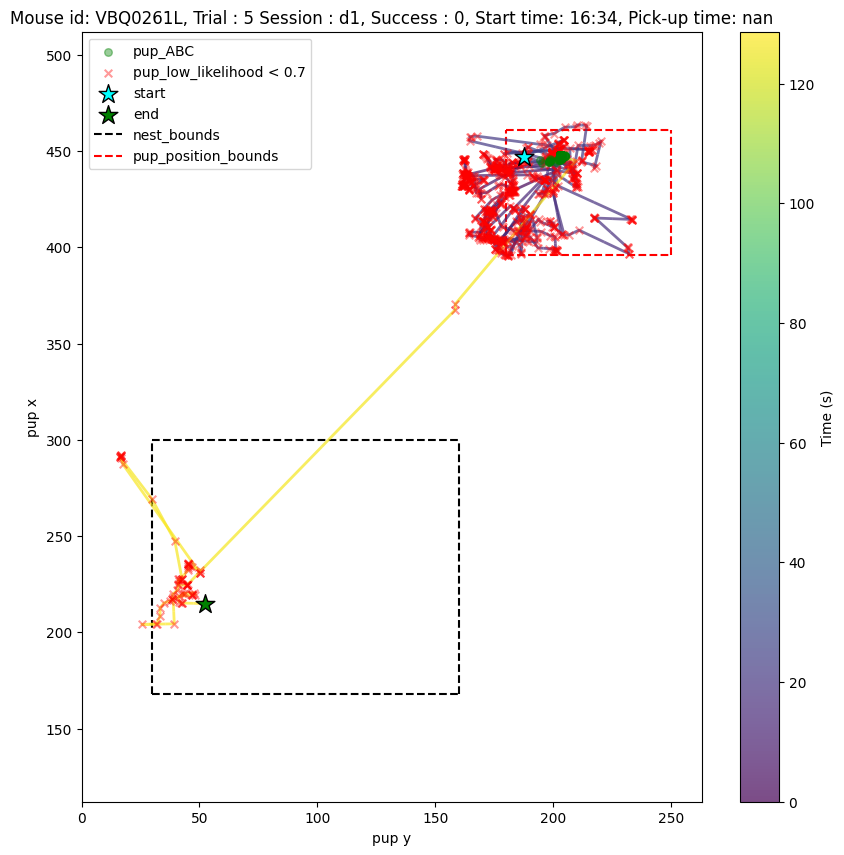

Number of data points in each cluster: cluster_label
0    3089
Name: count, dtype: int64


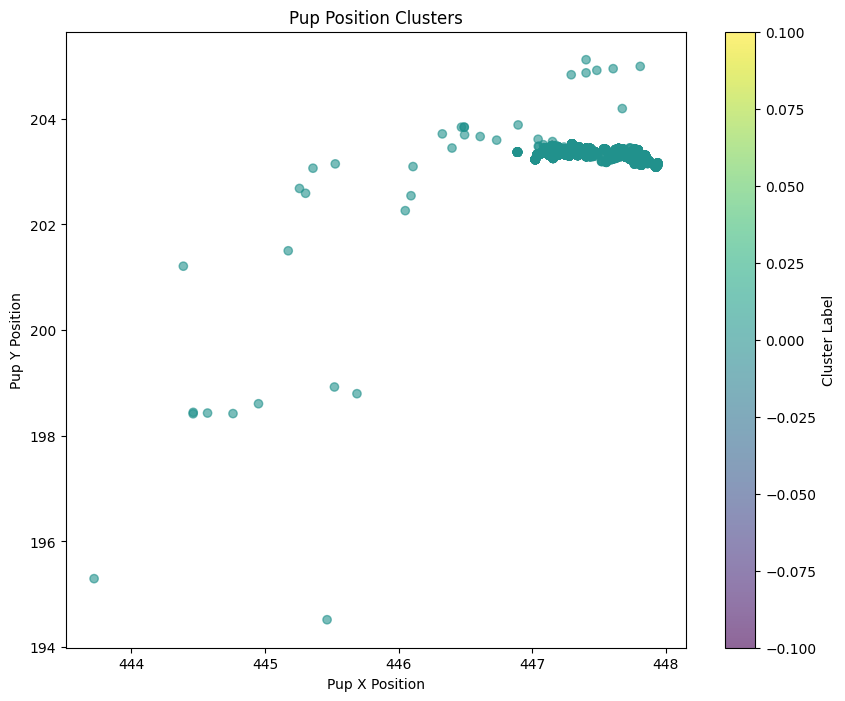

Cluster windows:  1
[{'cluster': 0.0,
  'end_time': 1120.7333333333333,
  'n_points': 3089,
  'start_time': 1013.5666666666667}]
== * == * Groups:  1
[[{'cluster': 0.0,
   'end_time': 1120.7333333333333,
   'n_points': 3089,
   'start_time': 1013.5666666666667}]]
Remaining clusters: [0.0]
No pick up time
Mean distance to pup box: 2.127792893791262 cm


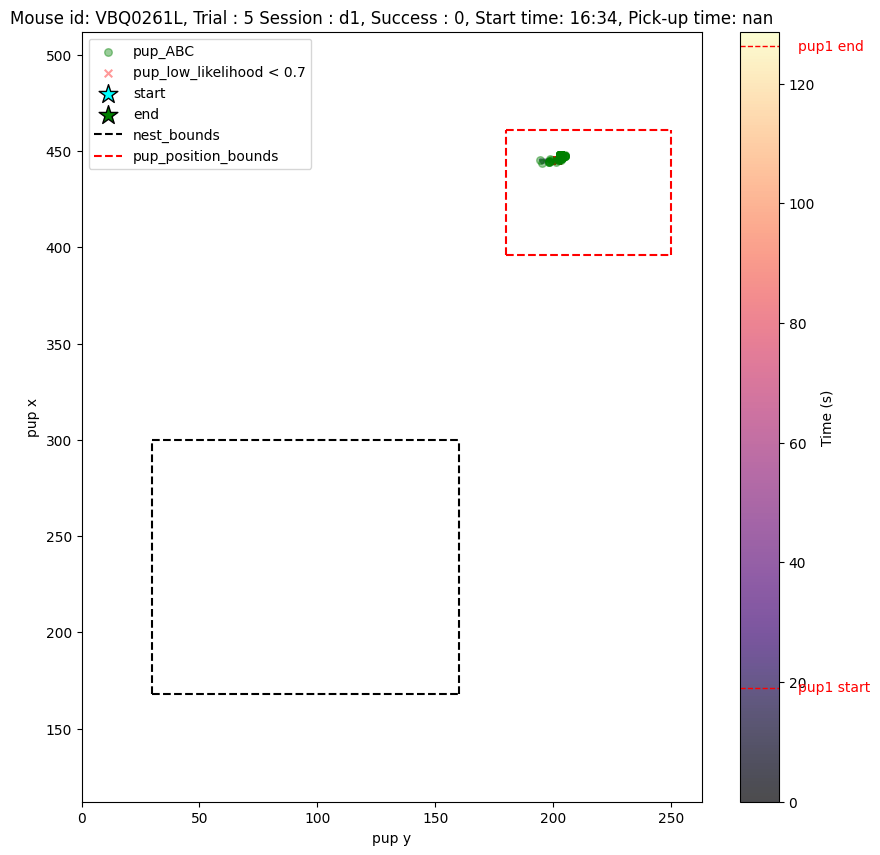

Before filtering:
Zeros in pupA_likelihood: 0
Zeros in pupB_likelihood: 0
Zeros in pupC_likelihood: 0

After intra pup filter:
Zeros in pupA_likelihood: 100
Zeros in pupB_likelihood: 58
Zeros in pupC_likelihood: 96
Number of implausible speed measurements for pupA: 142, initially high likelihood: 6
Number of implausible speed measurements for pupB: 137, initially high likelihood: 5
Number of implausible speed measurements for pupC: 134, initially high likelihood: 8

After speed filter:
Zeros in pupA_likelihood: 214
Zeros in pupB_likelihood: 174
Zeros in pupC_likelihood: 209
Number of NaNs in pup_average: 0


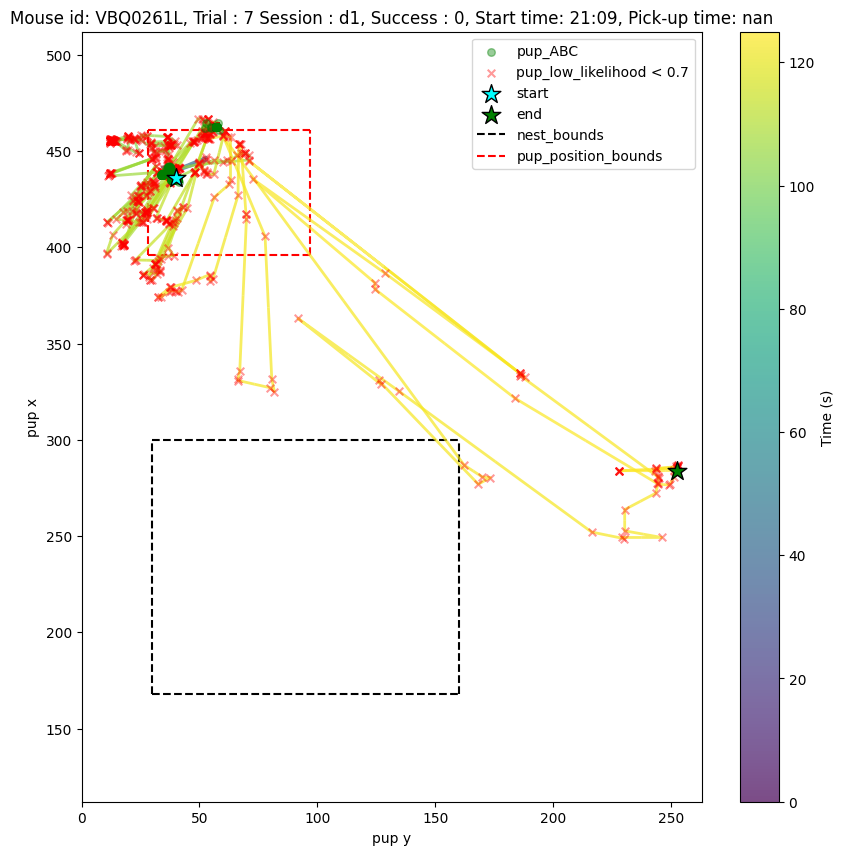

Number of data points in each cluster: cluster_label
0    3035
1      59
Name: count, dtype: int64


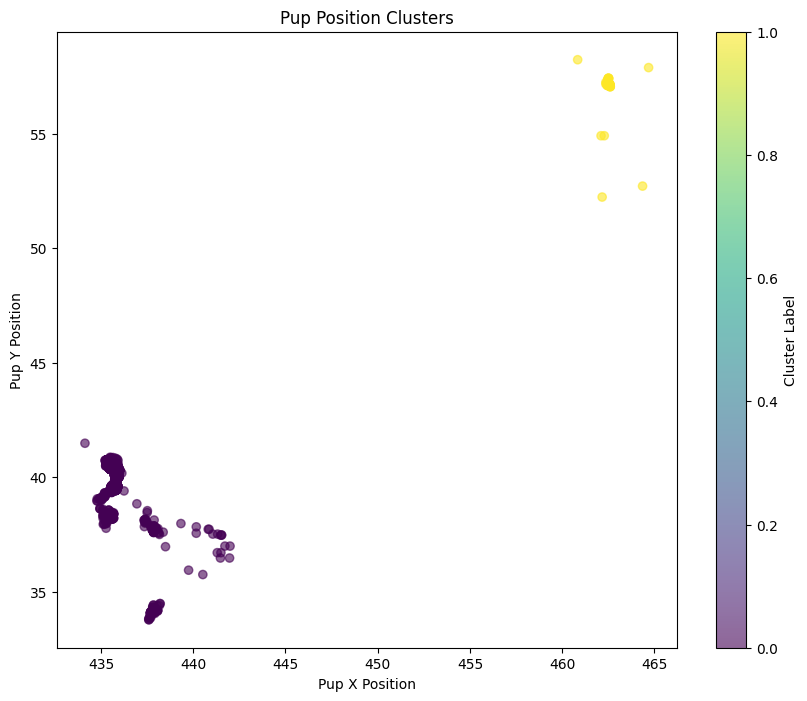

Cluster windows:  2
[{'cluster': 0.0,
  'end_time': 1371.5333333333333,
  'n_points': 3035,
  'start_time': 1269.8333333333333},
 {'cluster': 1.0,
  'end_time': 1391.0333333333333,
  'n_points': 59,
  'start_time': 1383.4666666666667}]
== * == * Groups:  2
[[{'cluster': 0.0,
   'end_time': 1371.5333333333333,
   'n_points': 3035,
   'start_time': 1269.8333333333333}],
 [{'cluster': 1.0,
   'end_time': 1391.0333333333333,
   'n_points': 59,
   'start_time': 1383.4666666666667}]]
Remaining clusters: [0.0]
No pick up time
Mean distance to pup box: 2.253020271200949 cm
Remaining clusters: [1.0]
No pick up time
Mean distance to pup box: 3.3082491992644645 cm


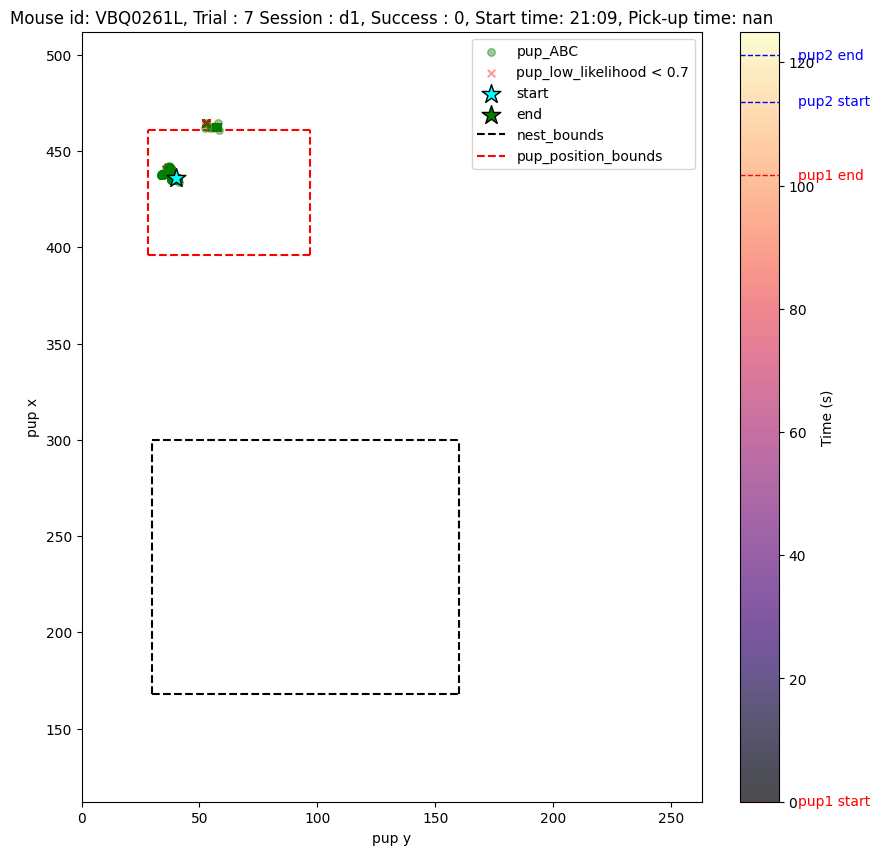

Before filtering:
Zeros in pupA_likelihood: 0
Zeros in pupB_likelihood: 0
Zeros in pupC_likelihood: 0

After intra pup filter:
Zeros in pupA_likelihood: 109
Zeros in pupB_likelihood: 78
Zeros in pupC_likelihood: 44
Number of implausible speed measurements for pupA: 246, initially high likelihood: 1
Number of implausible speed measurements for pupB: 201, initially high likelihood: 4
Number of implausible speed measurements for pupC: 248, initially high likelihood: 1

After speed filter:
Zeros in pupA_likelihood: 338
Zeros in pupB_likelihood: 261
Zeros in pupC_likelihood: 279
Number of NaNs in pup_average: 0


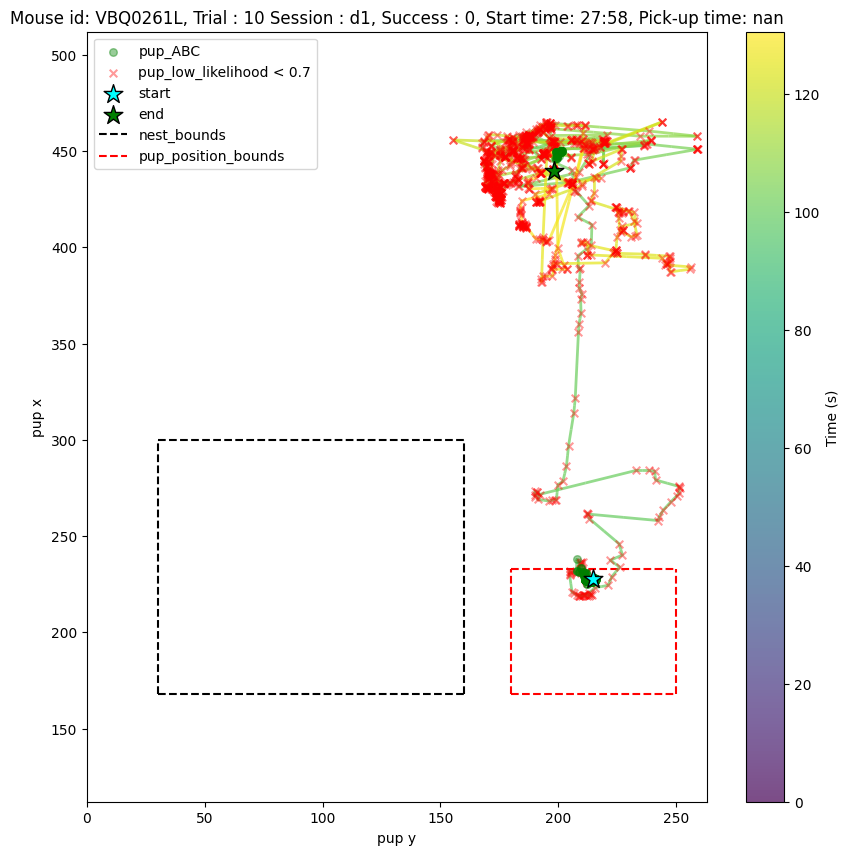

Number of data points in each cluster: cluster_label
0    2945
1      42
Name: count, dtype: int64


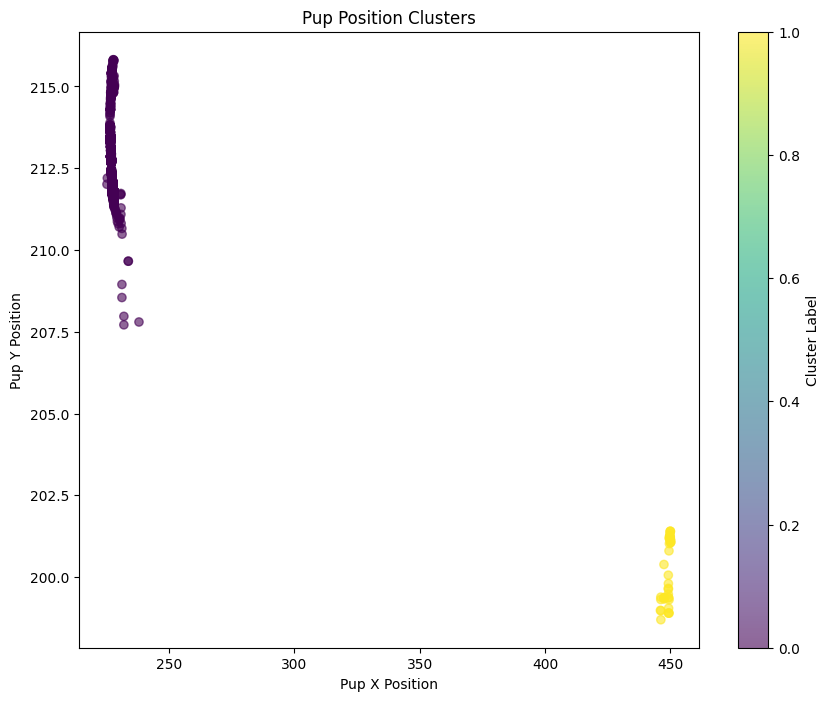

Cluster windows:  2
[{'cluster': 0.0, 'end_time': 1776.4, 'n_points': 2945, 'start_time': 1678.2},
 {'cluster': 1.0, 'end_time': 1805.9, 'n_points': 42, 'start_time': 1804.3}]
== * == * Groups:  2
[[{'cluster': 0.0, 'end_time': 1776.4, 'n_points': 2945, 'start_time': 1678.2}],
 [{'cluster': 1.0, 'end_time': 1805.9, 'n_points': 42, 'start_time': 1804.3}]]
Remaining clusters: [0.0]
No pick up time
Mean distance to pup box: 2.5957050942130193 cm
Remaining clusters: [1.0]
No pick up time
Mean distance to pup box: 23.89316609122655 cm
Removed cluster 1.0 from group


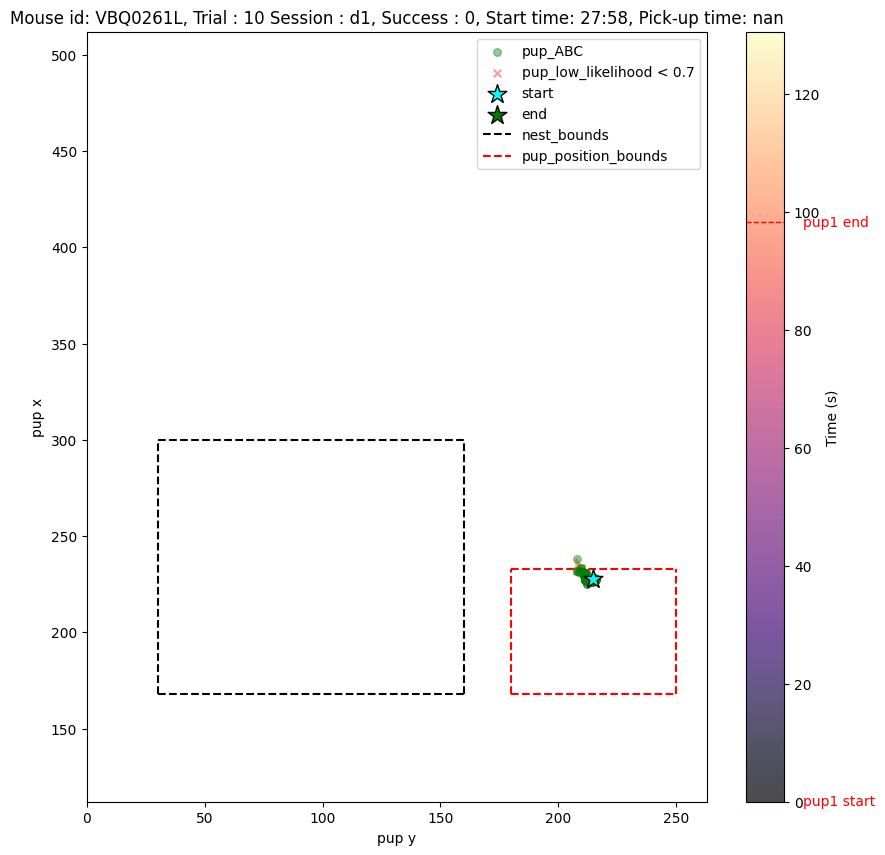

Before filtering:
Zeros in pupA_likelihood: 0
Zeros in pupB_likelihood: 0
Zeros in pupC_likelihood: 0

After intra pup filter:
Zeros in pupA_likelihood: 0
Zeros in pupB_likelihood: 7
Zeros in pupC_likelihood: 5
Number of implausible speed measurements for pupA: 95, initially high likelihood: 4
Number of implausible speed measurements for pupB: 71, initially high likelihood: 4
Number of implausible speed measurements for pupC: 79, initially high likelihood: 4

After speed filter:
Zeros in pupA_likelihood: 95
Zeros in pupB_likelihood: 75
Zeros in pupC_likelihood: 84
Number of NaNs in pup_average: 0


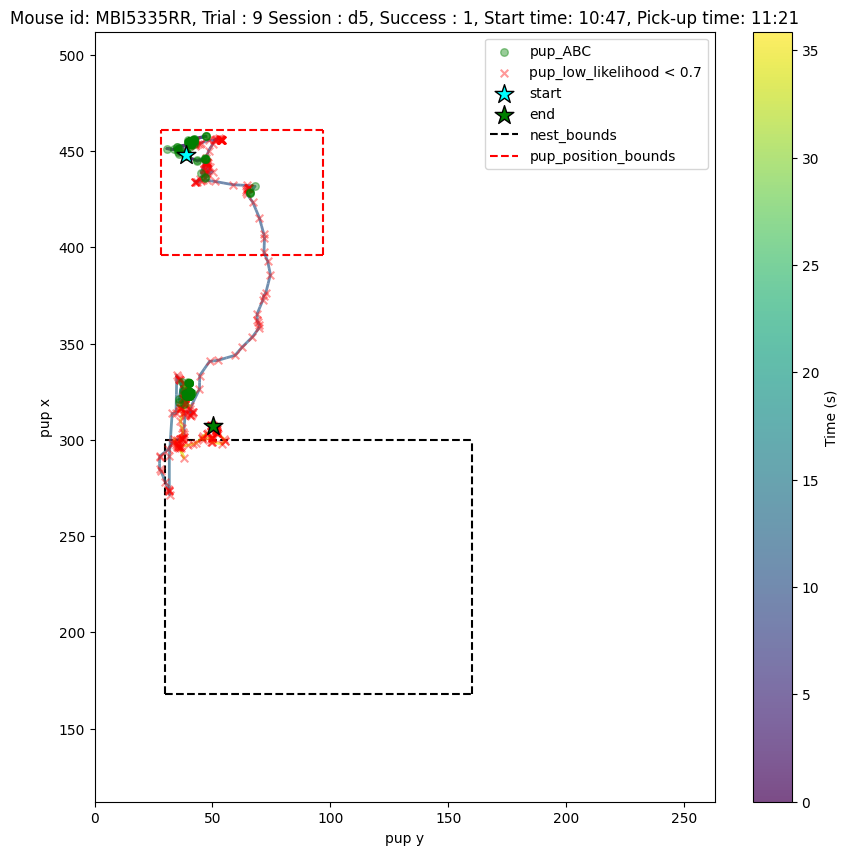

Number of data points in each cluster: cluster_label
 1    598
 0    233
-1      6
Name: count, dtype: int64


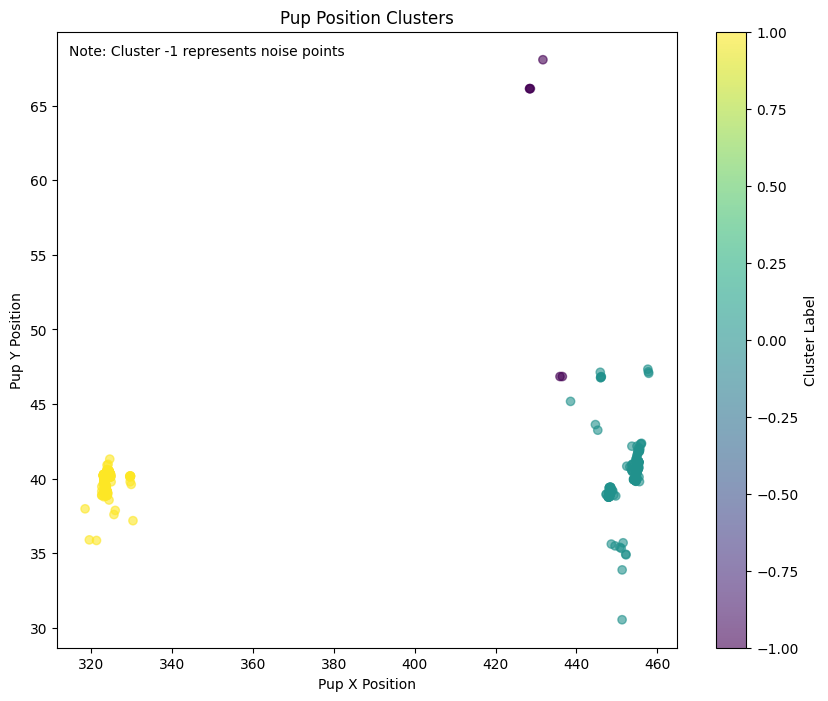

Cluster windows:  2
[{'cluster': 0.0,
  'end_time': 657.1666666666666,
  'n_points': 233,
  'start_time': 647.8333333333334},
 {'cluster': 1.0,
  'end_time': 680.4,
  'n_points': 598,
  'start_time': 660.4333333333333}]
== * == * Groups:  2
[[{'cluster': 0.0,
   'end_time': 657.1666666666666,
   'n_points': 233,
   'start_time': 647.8333333333334}],
 [{'cluster': 1.0,
   'end_time': 680.4,
   'n_points': 598,
   'start_time': 660.4333333333333}]]
Remaining clusters: [0.0]
Remaining clusters: [1.0]


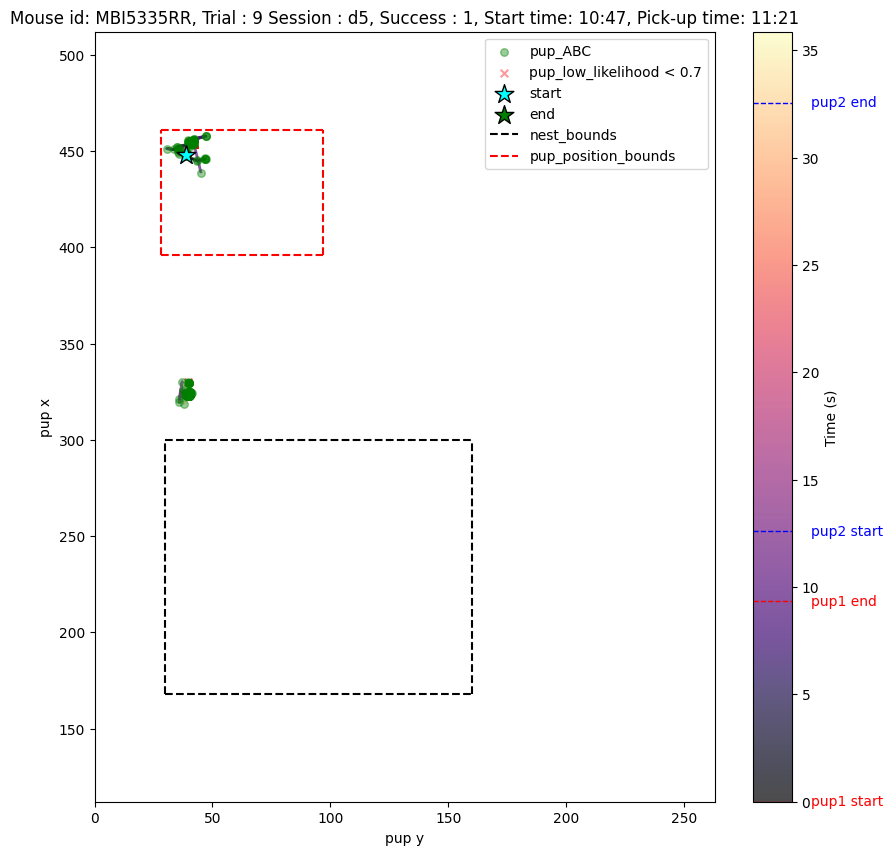

Before filtering:
Zeros in pupA_likelihood: 0
Zeros in pupB_likelihood: 0
Zeros in pupC_likelihood: 0

After intra pup filter:
Zeros in pupA_likelihood: 220
Zeros in pupB_likelihood: 61
Zeros in pupC_likelihood: 82
Number of implausible speed measurements for pupA: 258, initially high likelihood: 44
Number of implausible speed measurements for pupB: 90, initially high likelihood: 27
Number of implausible speed measurements for pupC: 132, initially high likelihood: 59

After speed filter:
Zeros in pupA_likelihood: 394
Zeros in pupB_likelihood: 140
Zeros in pupC_likelihood: 193
Number of NaNs in pup_average: 0


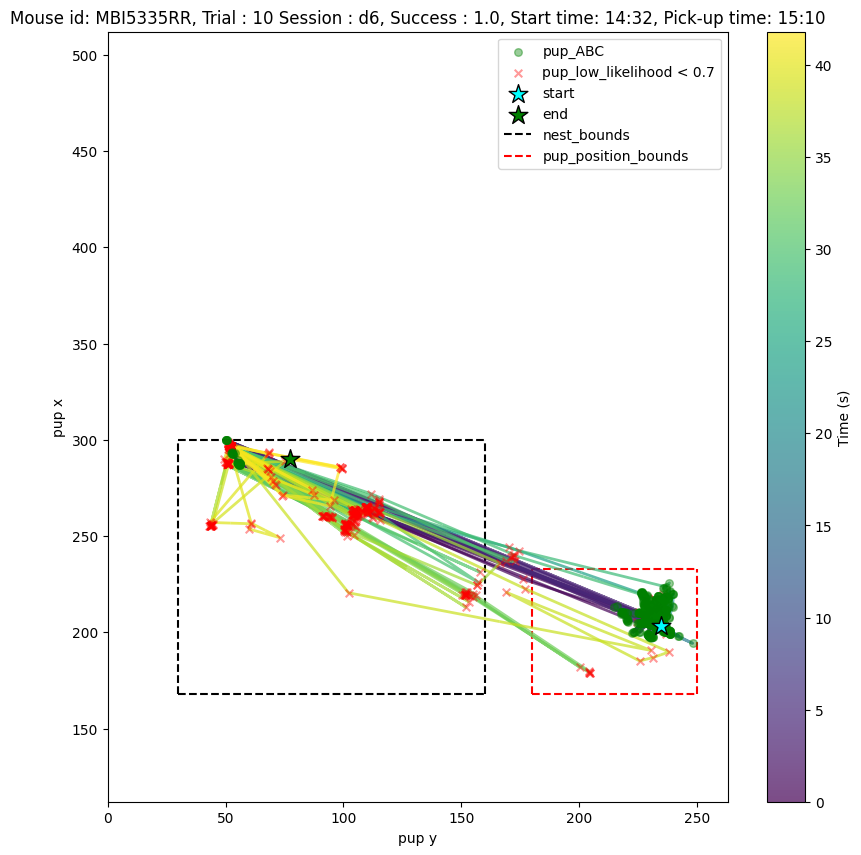

Number of data points in each cluster: cluster_label
 0    661
 1     56
-1      1
Name: count, dtype: int64


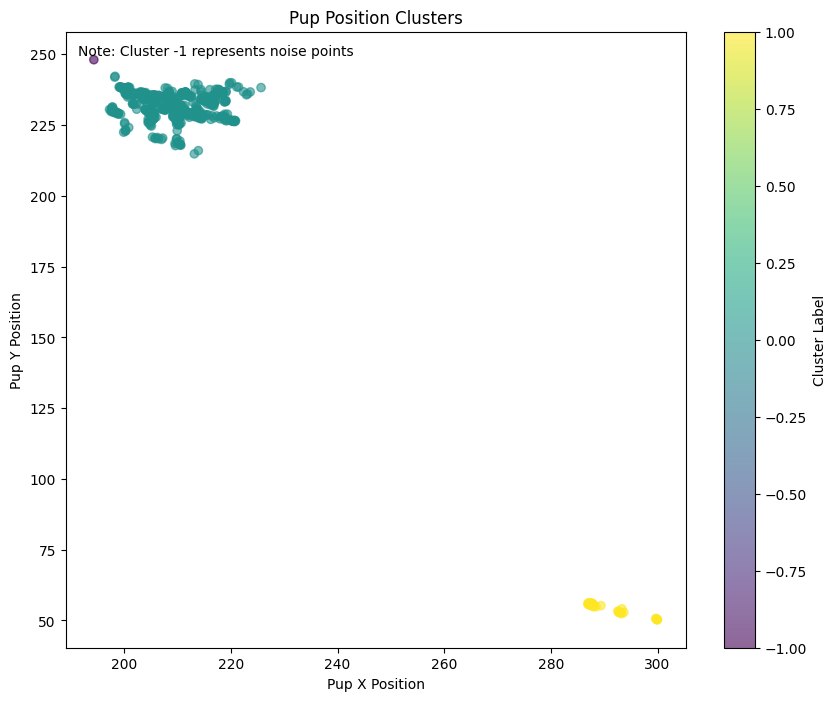

Cluster windows:  2
[{'cluster': 0.0,
  'end_time': 901.5666666666667,
  'n_points': 661,
  'start_time': 872.7333333333333},
 {'cluster': 1.0,
  'end_time': 877.3666666666667,
  'n_points': 56,
  'start_time': 873.0333333333333}]
== * == * Groups:  1
[[{'cluster': 0.0,
   'end_time': 901.5666666666667,
   'n_points': 661,
   'start_time': 872.7333333333333},
  {'cluster': 1.0,
   'end_time': 877.3666666666667,
   'n_points': 56,
   'start_time': 873.0333333333333}]]
Furthest cluster: 1.0
Max distance to pup box: 183.57928467632044 cm
Speeds max:  608.3057881608275
Speeds min:  1.4643751526759642e-05
Removed furthest cluster
---> Removed cluster was 1.0
Remaining clusters: [0.0]


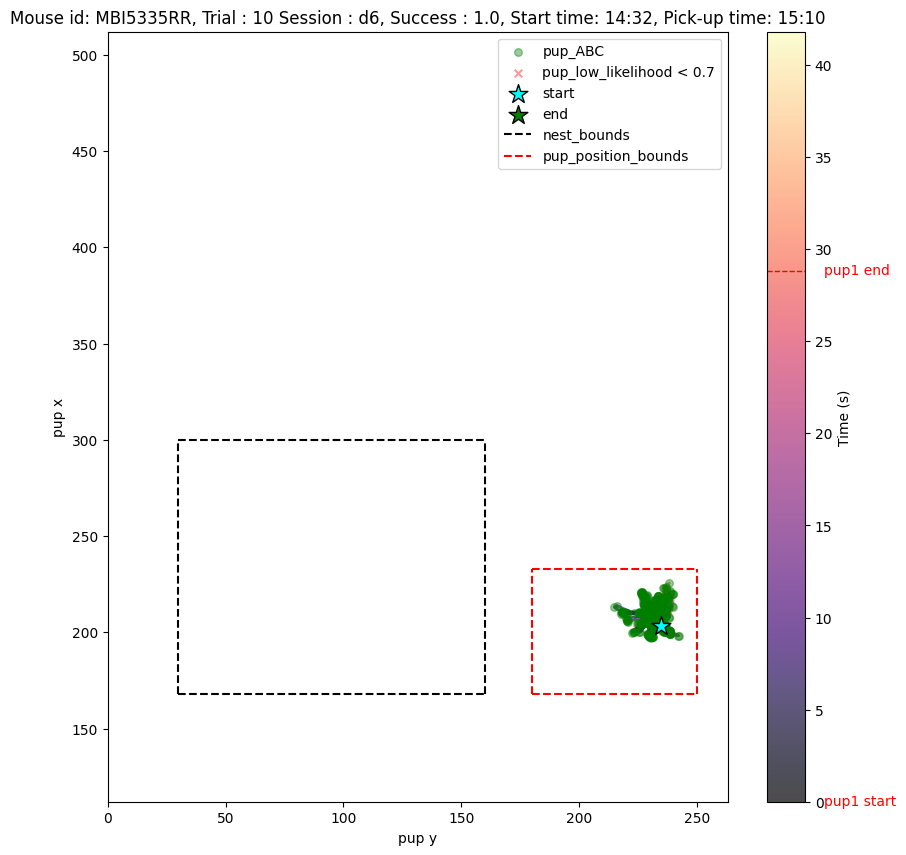

Before filtering:
Zeros in pupA_likelihood: 0
Zeros in pupB_likelihood: 0
Zeros in pupC_likelihood: 0

After intra pup filter:
Zeros in pupA_likelihood: 92
Zeros in pupB_likelihood: 298
Zeros in pupC_likelihood: 77
Number of implausible speed measurements for pupA: 28, initially high likelihood: 23
Number of implausible speed measurements for pupB: 27, initially high likelihood: 17
Number of implausible speed measurements for pupC: 33, initially high likelihood: 27

After speed filter:
Zeros in pupA_likelihood: 118
Zeros in pupB_likelihood: 315
Zeros in pupC_likelihood: 104
Number of NaNs in pup_average: 0


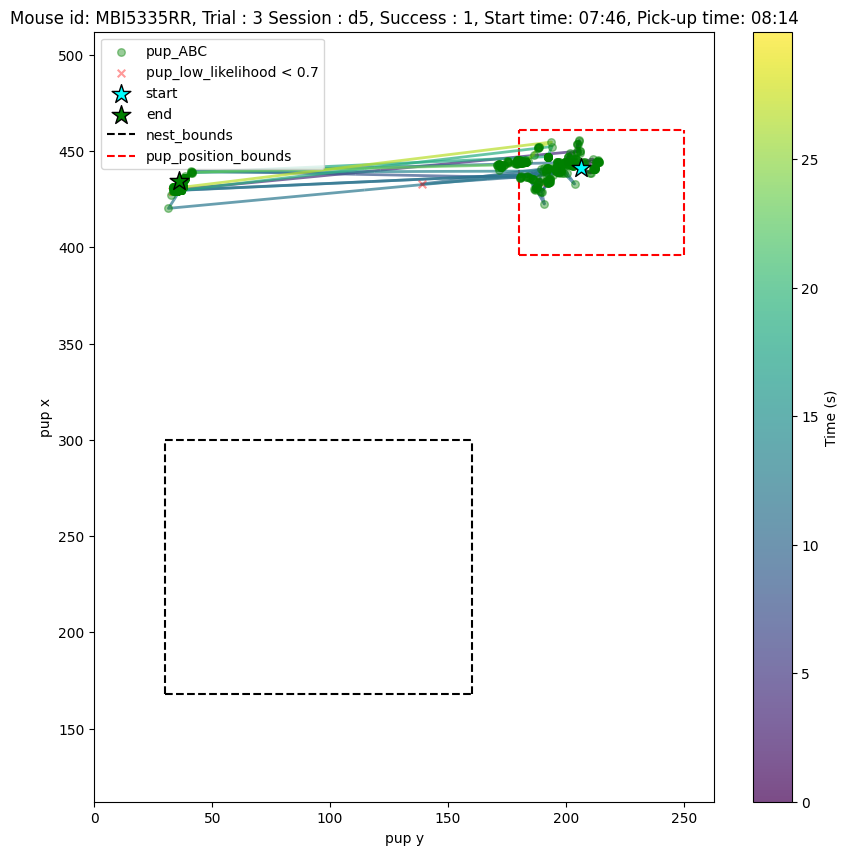

Number of data points in each cluster: cluster_label
 1    515
 0    381
-1      1
Name: count, dtype: int64


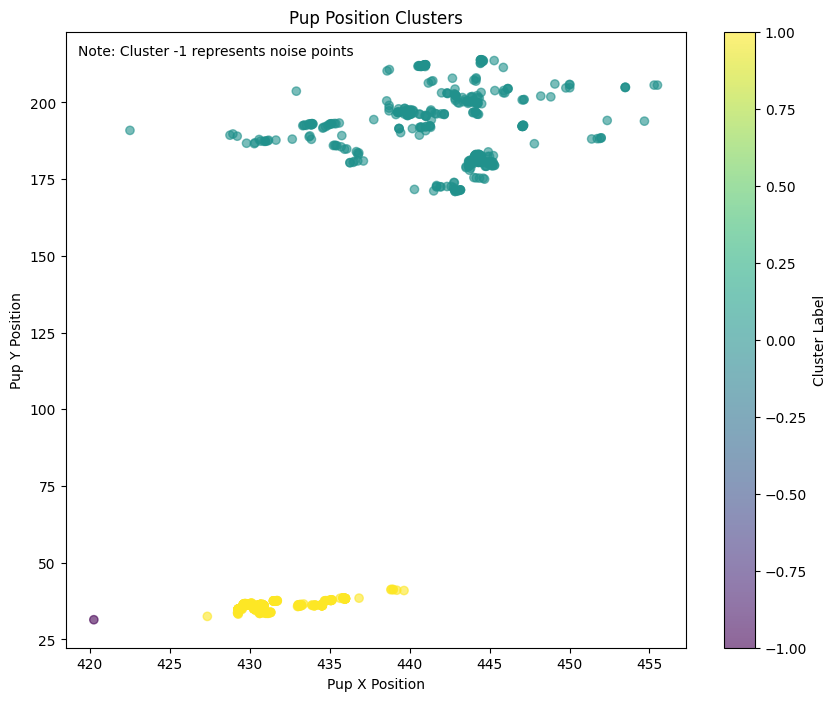

Cluster windows:  2
[{'cluster': 0.0,
  'end_time': 493.23333333333335,
  'n_points': 381,
  'start_time': 466.5},
 {'cluster': 1.0,
  'end_time': 496.46666666666664,
  'n_points': 515,
  'start_time': 470.1333333333333}]
== * == * Groups:  1
[[{'cluster': 0.0,
   'end_time': 493.23333333333335,
   'n_points': 381,
   'start_time': 466.5},
  {'cluster': 1.0,
   'end_time': 496.46666666666664,
   'n_points': 515,
   'start_time': 470.1333333333333}]]
Furthest cluster: 1.0
Max distance to pup box: 178.8510836214016 cm
Speeds max:  490.0830757754246
Speeds min:  0.0
Removed furthest cluster
---> Removed cluster was 1.0
Remaining clusters: [0.0]


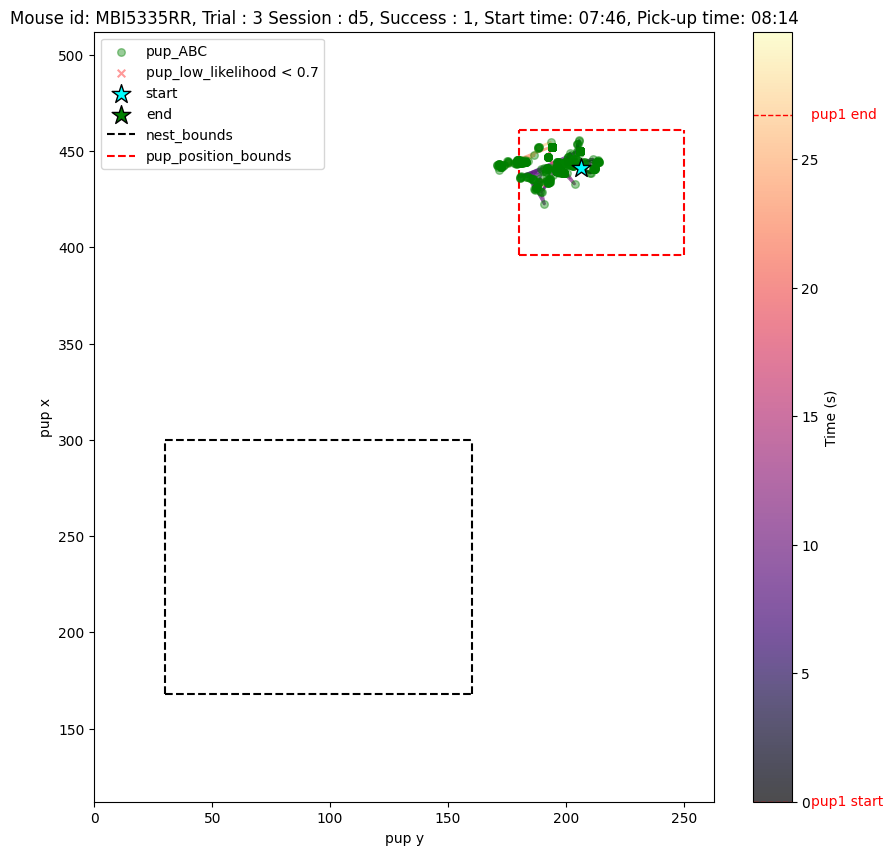

Before filtering:
Zeros in pupA_likelihood: 0
Zeros in pupB_likelihood: 0
Zeros in pupC_likelihood: 0

After intra pup filter:
Zeros in pupA_likelihood: 185
Zeros in pupB_likelihood: 158
Zeros in pupC_likelihood: 91
Number of implausible speed measurements for pupA: 320, initially high likelihood: 93
Number of implausible speed measurements for pupB: 110, initially high likelihood: 44
Number of implausible speed measurements for pupC: 267, initially high likelihood: 92

After speed filter:
Zeros in pupA_likelihood: 423
Zeros in pupB_likelihood: 249
Zeros in pupC_likelihood: 329
Number of NaNs in pup_average: 0


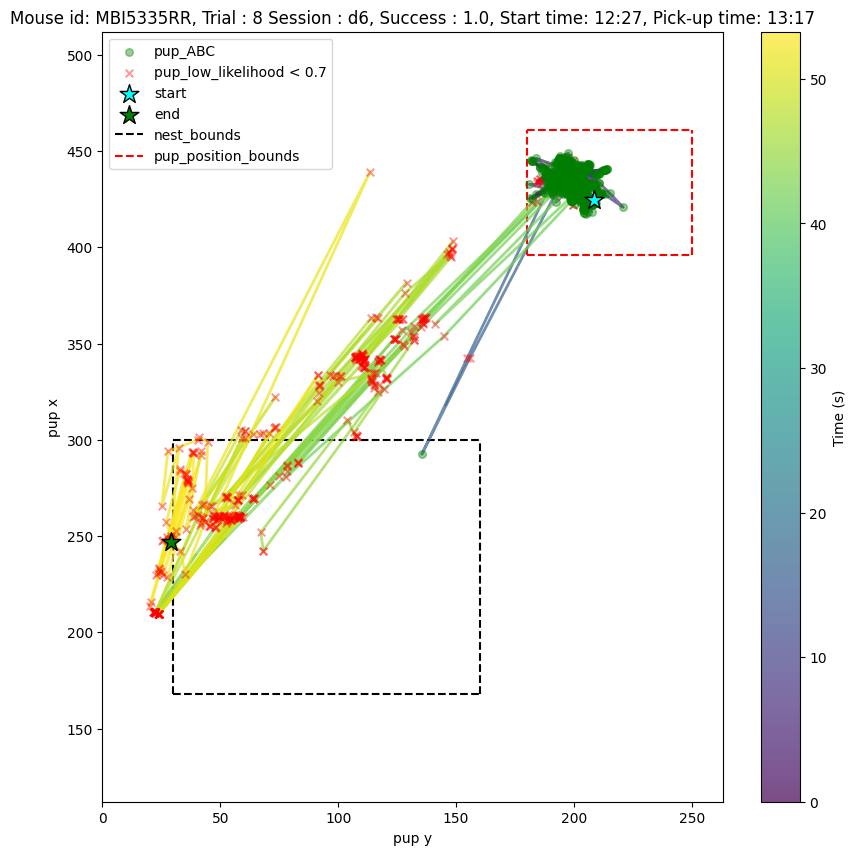

Number of data points in each cluster: cluster_label
 0    1198
-1       2
Name: count, dtype: int64


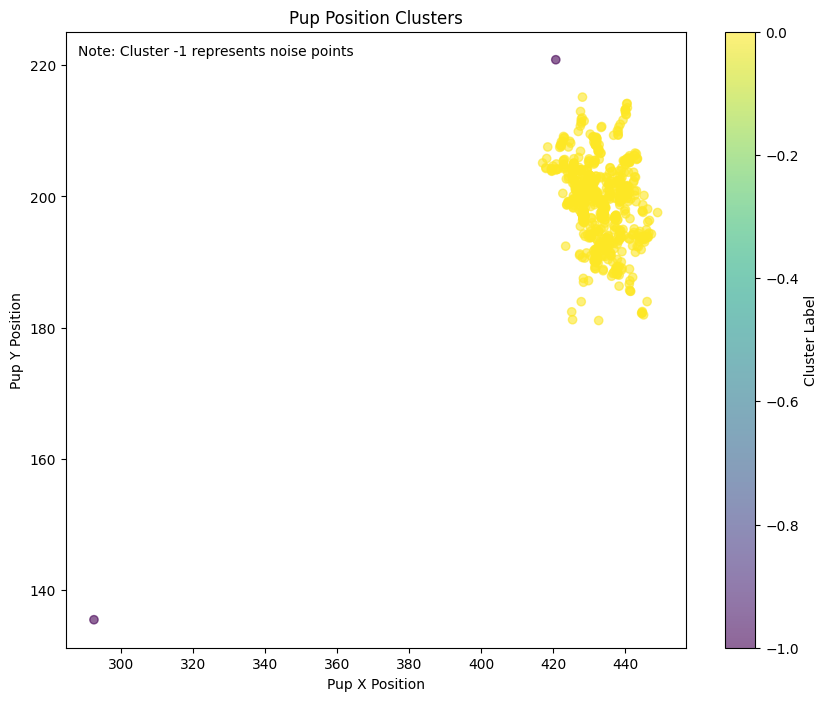

Cluster windows:  1
[{'cluster': 0.0,
  'end_time': 788.7666666666667,
  'n_points': 1198,
  'start_time': 747.6333333333333}]
== * == * Groups:  1
[[{'cluster': 0.0,
   'end_time': 788.7666666666667,
   'n_points': 1198,
   'start_time': 747.6333333333333}]]
Remaining clusters: [0.0]


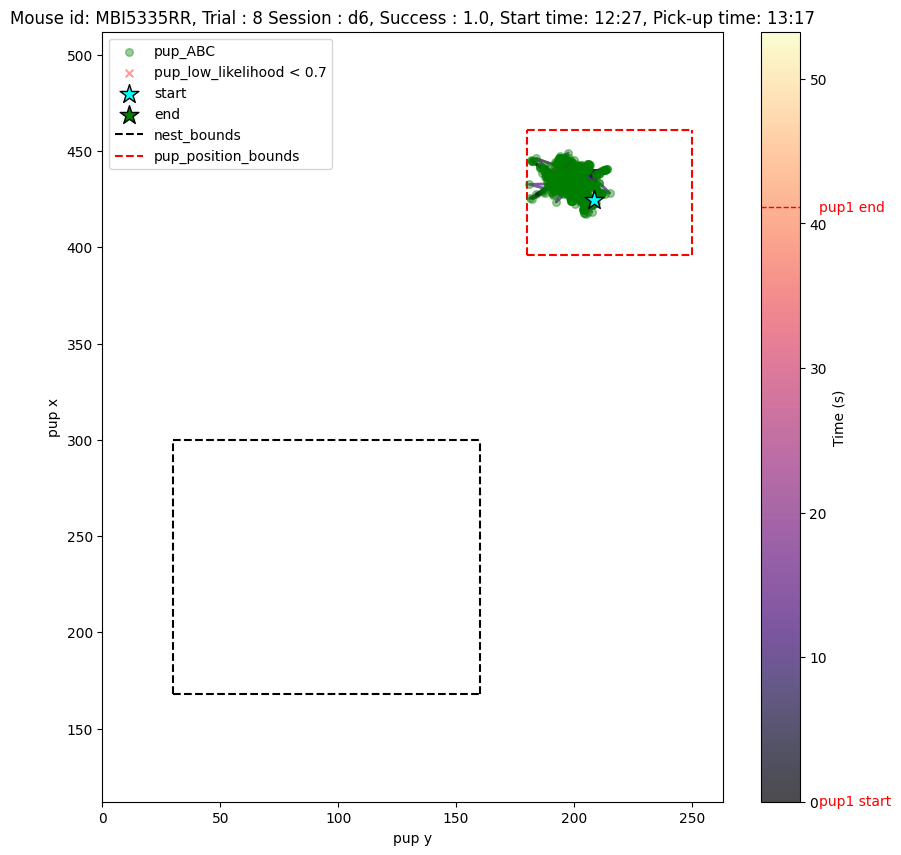

Before filtering:
Zeros in pupA_likelihood: 0
Zeros in pupB_likelihood: 0
Zeros in pupC_likelihood: 0

After intra pup filter:
Zeros in pupA_likelihood: 2
Zeros in pupB_likelihood: 3
Zeros in pupC_likelihood: 0
Number of implausible speed measurements for pupA: 341, initially high likelihood: 306
Number of implausible speed measurements for pupB: 109, initially high likelihood: 80
Number of implausible speed measurements for pupC: 373, initially high likelihood: 332

After speed filter:
Zeros in pupA_likelihood: 342
Zeros in pupB_likelihood: 112
Zeros in pupC_likelihood: 373
Number of NaNs in pup_average: 0


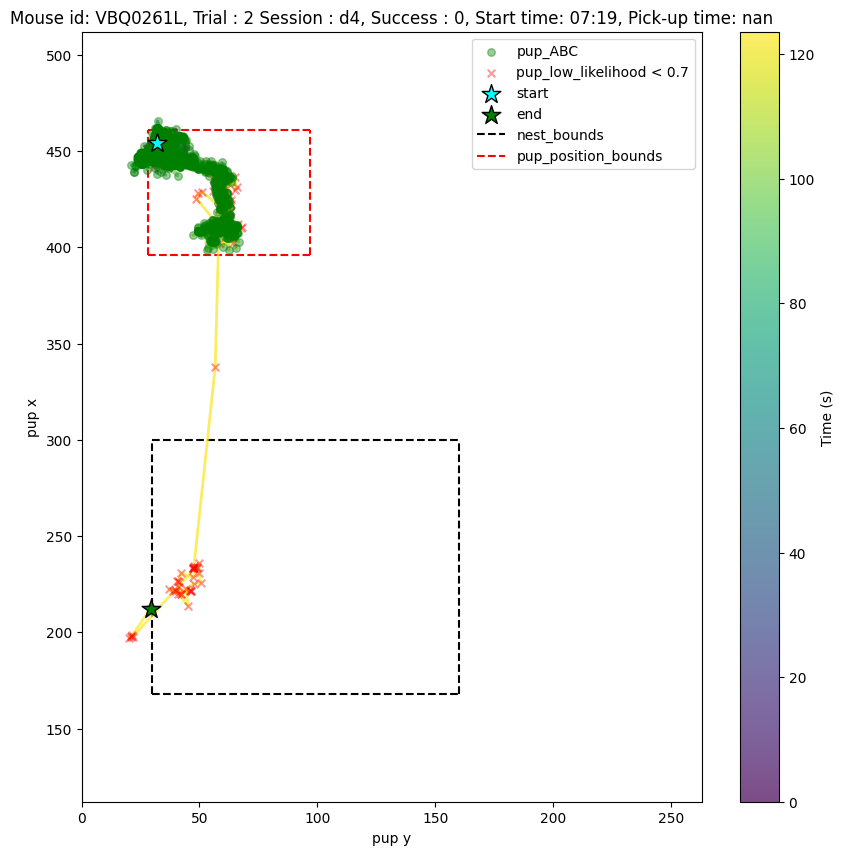

Number of data points in each cluster: cluster_label
0    3625
Name: count, dtype: int64


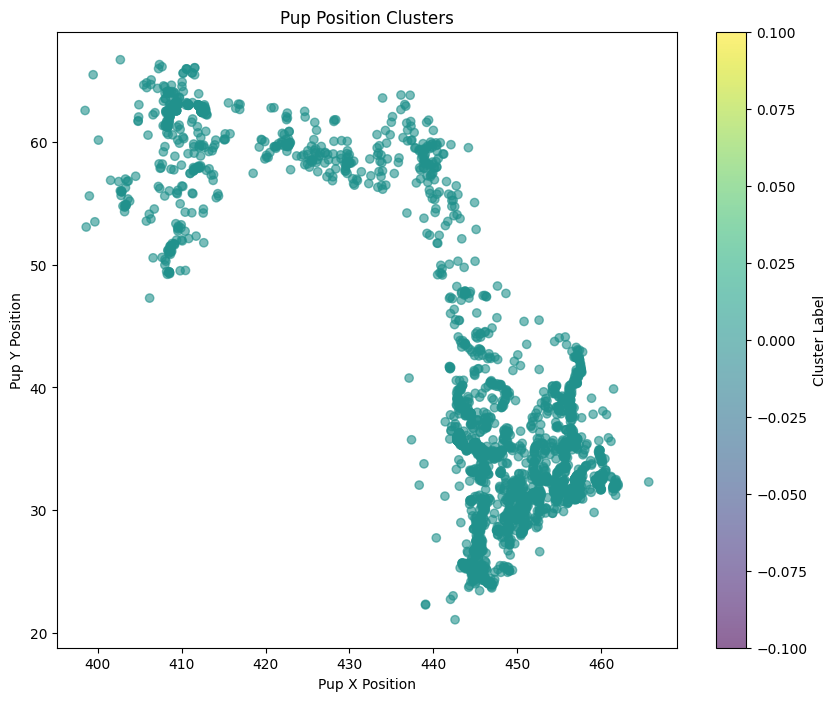

Cluster windows:  1
[{'cluster': 0.0,
  'end_time': 560.9333333333333,
  'n_points': 3625,
  'start_time': 439.6333333333333}]
== * == * Groups:  1
[[{'cluster': 0.0,
   'end_time': 560.9333333333333,
   'n_points': 3625,
   'start_time': 439.6333333333333}]]
Remaining clusters: [0.0]
No pick up time
Mean distance to pup box: 2.7108566759680333 cm


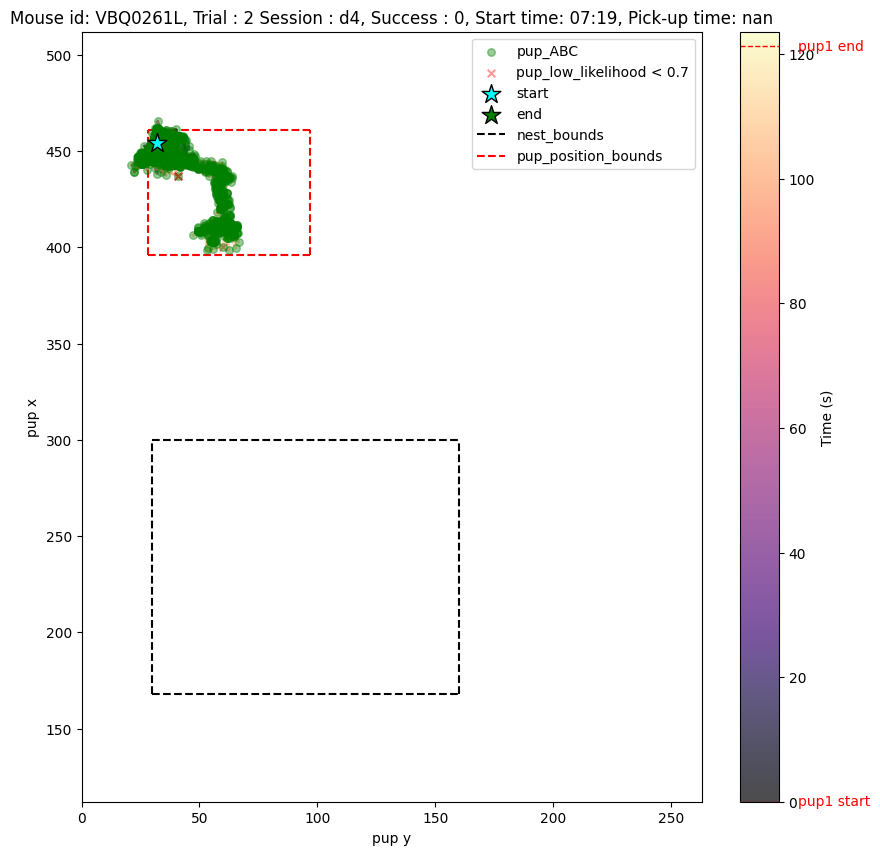

Before filtering:
Zeros in pupA_likelihood: 0
Zeros in pupB_likelihood: 0
Zeros in pupC_likelihood: 0

After intra pup filter:
Zeros in pupA_likelihood: 79
Zeros in pupB_likelihood: 41
Zeros in pupC_likelihood: 126
Number of implausible speed measurements for pupA: 460, initially high likelihood: 99
Number of implausible speed measurements for pupB: 379, initially high likelihood: 81
Number of implausible speed measurements for pupC: 414, initially high likelihood: 85

After speed filter:
Zeros in pupA_likelihood: 501
Zeros in pupB_likelihood: 397
Zeros in pupC_likelihood: 486
Number of NaNs in pup_average: 0


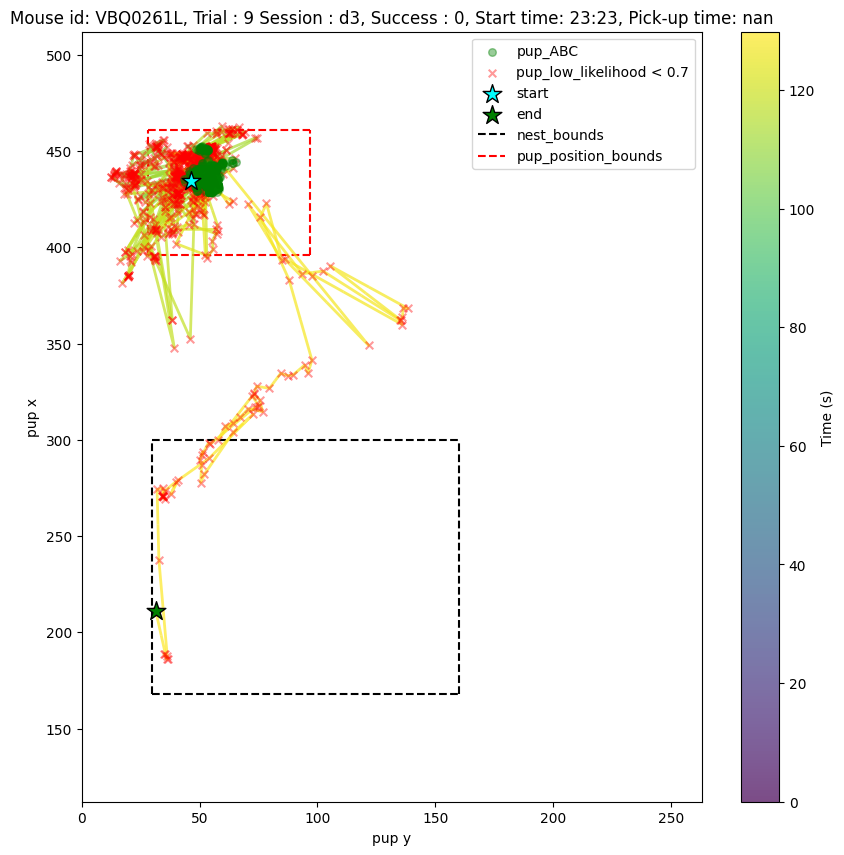

Number of data points in each cluster: cluster_label
0    3034
Name: count, dtype: int64


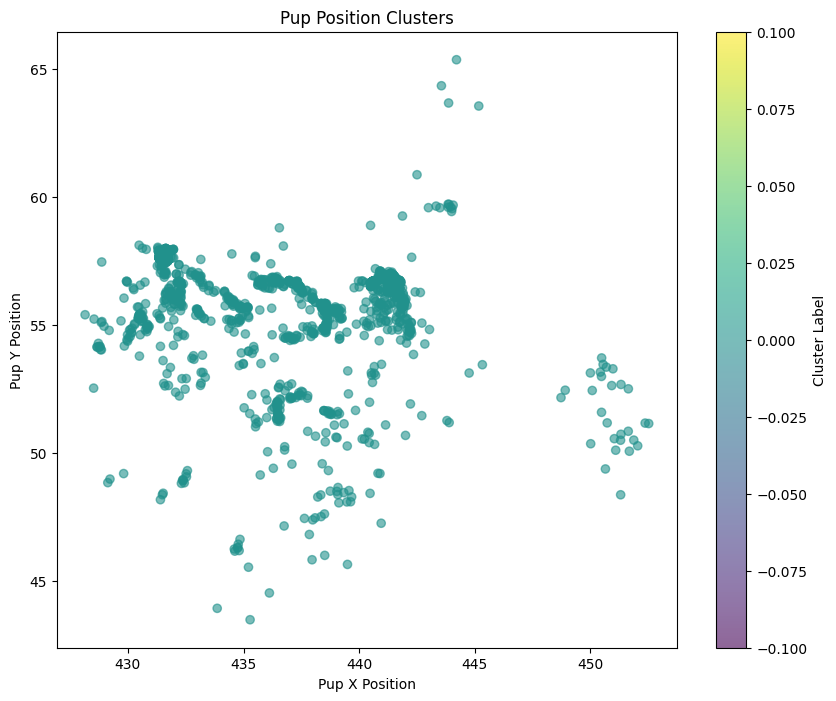

Cluster windows:  1
[{'cluster': 0.0,
  'end_time': 1531.3666666666666,
  'n_points': 3034,
  'start_time': 1403.9666666666667}]
== * == * Groups:  1
[[{'cluster': 0.0,
   'end_time': 1531.3666666666666,
   'n_points': 3034,
   'start_time': 1403.9666666666667}]]
Remaining clusters: [0.0]
No pick up time
Mean distance to pup box: 1.182469881826398 cm


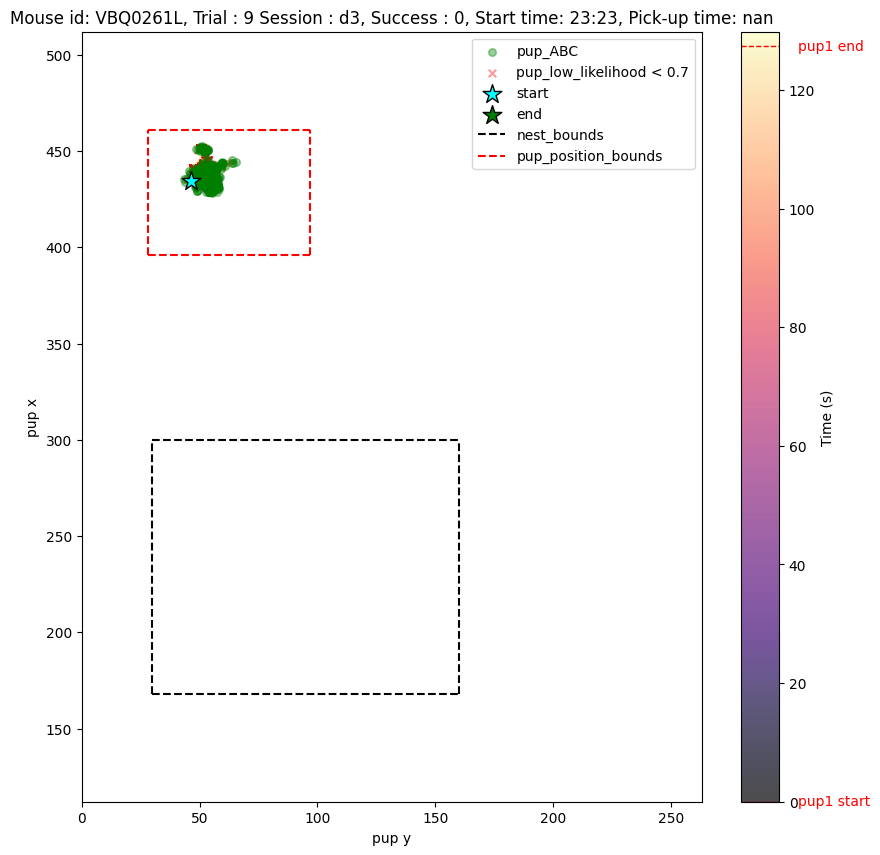

Before filtering:
Zeros in pupA_likelihood: 0
Zeros in pupB_likelihood: 0
Zeros in pupC_likelihood: 0

After intra pup filter:
Zeros in pupA_likelihood: 96
Zeros in pupB_likelihood: 215
Zeros in pupC_likelihood: 147
Number of implausible speed measurements for pupA: 568, initially high likelihood: 5
Number of implausible speed measurements for pupB: 545, initially high likelihood: 12
Number of implausible speed measurements for pupC: 383, initially high likelihood: 15

After speed filter:
Zeros in pupA_likelihood: 613
Zeros in pupB_likelihood: 664
Zeros in pupC_likelihood: 514
Number of NaNs in pup_average: 0


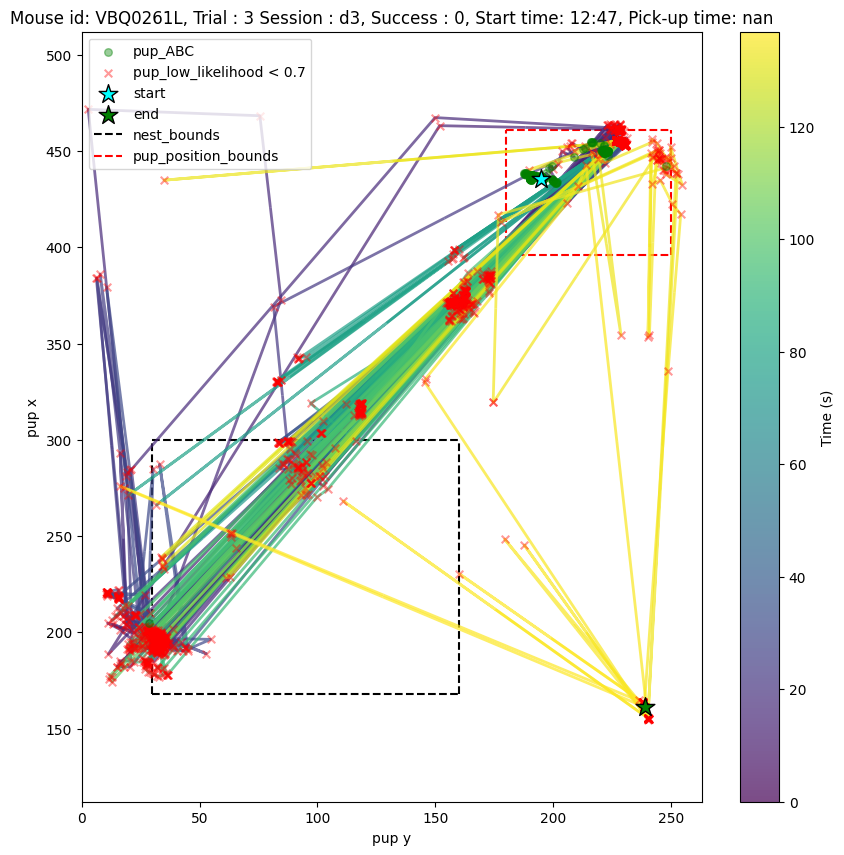

Number of data points in each cluster: cluster_label
 0    309
 1     53
-1      2
Name: count, dtype: int64


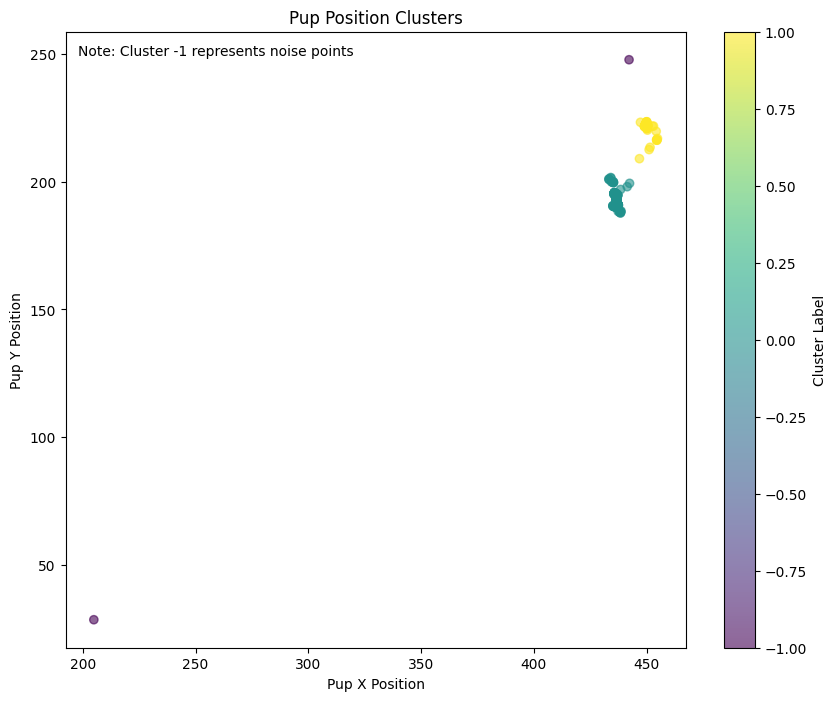

Cluster windows:  2
[{'cluster': 0.0,
  'end_time': 778.1,
  'n_points': 309,
  'start_time': 767.8333333333334},
 {'cluster': 1.0,
  'end_time': 780.1333333333333,
  'n_points': 53,
  'start_time': 778.2333333333333}]
== * == * Groups:  1
[[{'cluster': 0.0,
   'end_time': 778.1,
   'n_points': 309,
   'start_time': 767.8333333333334},
  {'cluster': 1.0,
   'end_time': 780.1333333333333,
   'n_points': 53,
   'start_time': 778.2333333333333}]]
Furthest cluster: 0.0
Max distance to pup box: 23.206040051037792 cm
Speeds max:  23.41371667904226
Speeds min:  6.212817592398476e-05
Remaining clusters: [0.0, 1.0]
No pick up time
Mean distance to pup box: 2.2254988763814705 cm
No pick up time
Mean distance to pup box: 2.173068914573382 cm


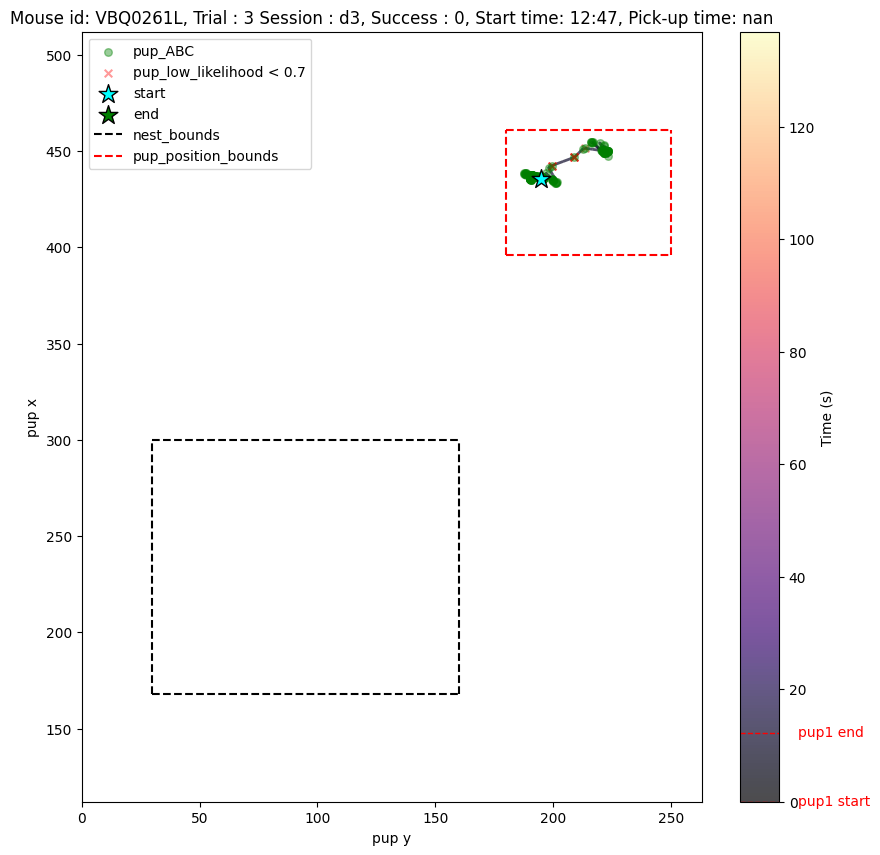

Before filtering:
Zeros in pupA_likelihood: 0
Zeros in pupB_likelihood: 0
Zeros in pupC_likelihood: 0

After intra pup filter:
Zeros in pupA_likelihood: 8
Zeros in pupB_likelihood: 25
Zeros in pupC_likelihood: 10
Number of implausible speed measurements for pupA: 218, initially high likelihood: 112
Number of implausible speed measurements for pupB: 124, initially high likelihood: 29
Number of implausible speed measurements for pupC: 252, initially high likelihood: 145

After speed filter:
Zeros in pupA_likelihood: 221
Zeros in pupB_likelihood: 131
Zeros in pupC_likelihood: 254
Number of NaNs in pup_average: 0


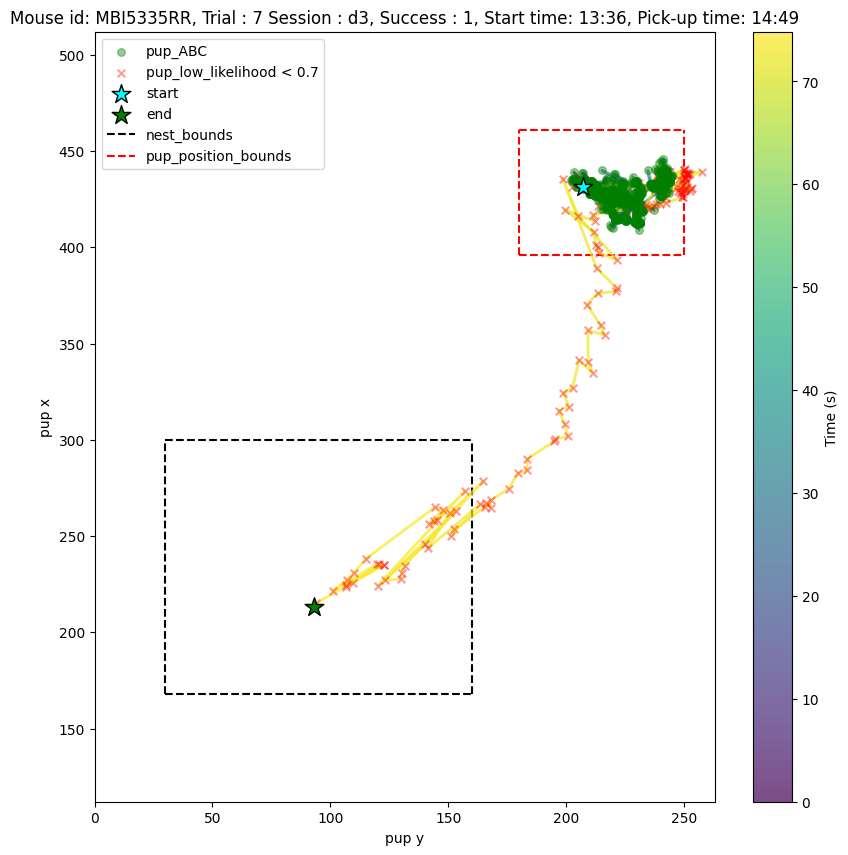

Number of data points in each cluster: cluster_label
0    2107
Name: count, dtype: int64


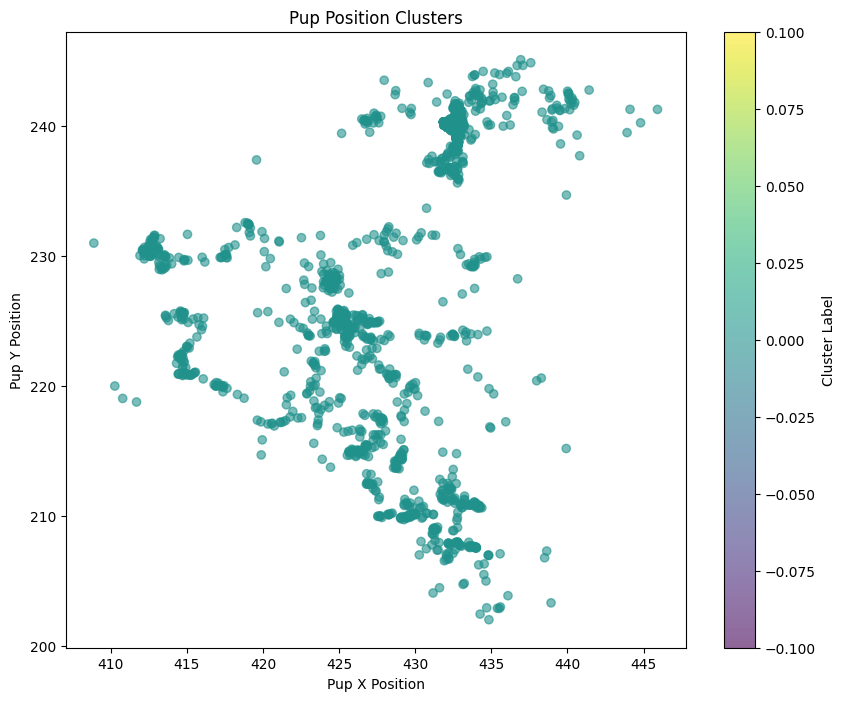

Cluster windows:  1
[{'cluster': 0.0,
  'end_time': 887.2333333333333,
  'n_points': 2107,
  'start_time': 816.7333333333333}]
== * == * Groups:  1
[[{'cluster': 0.0,
   'end_time': 887.2333333333333,
   'n_points': 2107,
   'start_time': 816.7333333333333}]]
Remaining clusters: [0.0]


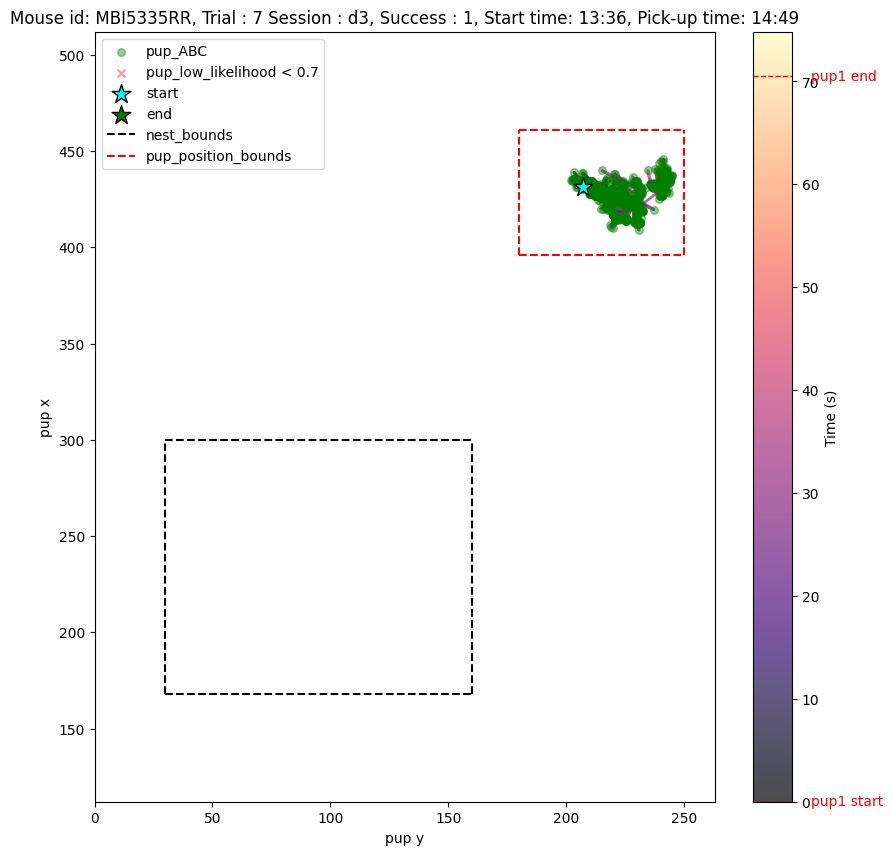

In [58]:
recomputed_trials = {}
case1 = noisy_cases[2:3]
case1 = [("VBQ0261L", "d3", 3)]
for case in few_point_cases + double_locations + noisy_cases + ideal_cases:
    ms_id, d, trial_num = case

    ### Testing pipeline
    trial_dlc = experiment_data[ms_id][d]["trials"][trial_num]["dlc_data"].copy()
    df_summary = experiment_data[ms_id][d]["Behavior"]["df_summary"].copy()

    ######## 1. compute distances between pup coordinates
    trial_dlc = compute_distances_intra_coords(BF, trial_dlc)

    # print number of 0s in pup_likelihood, pupA_likelihood, pupB_likelihood, pupC_likelihood
    print("Before filtering:")
    for col in ["pupA_likelihood", "pupB_likelihood", "pupC_likelihood"]:
        print(f"Zeros in {col}: {(trial_dlc[col] == 0).sum()}")

    ######## 2. filter out implausible pup coordinates
    trial_dlc = filter_intra_pup_coords(BF, trial_dlc, threshold_intra_distance_pup_cm=2.5)

    print("\nAfter intra pup filter:")
    for col in ["pupA_likelihood", "pupB_likelihood", "pupC_likelihood"]:
        print(f"Zeros in {col}: {(trial_dlc[col] == 0).sum()}")

    ######## 3. filter out implausible pup speeds
    trial_dlc = filter_speed_pup(BF, trial_dlc,
                                     threshold_speed_pup_cm = 5)
    print("\nAfter speed filter:")
    for col in ["pupA_likelihood", "pupB_likelihood", "pupC_likelihood"]:
        print(f"Zeros in {col}: {(trial_dlc[col] == 0).sum()}")

    ######## 4. recompute the pup average
    pup_coords = { key:values for key, values in BF.config["DLC_columns"].items() if key.startswith("pup") and len(key) == 4}
    trial_dlc[['pup_x','pup_y', 'pup_likelihood']] = trial_dlc.apply(lambda row: compute_pup_average(row, BF, threshold_likelihood_pup = 0.7), axis = 1, result_type = 'expand')
    # count number of NaNs in pup_average
    print(f"Number of NaNs in pup_average: {trial_dlc['pup_x'].isna().sum()}")
    
    ######## 5. visualize the pup trajectory
    visualize_pup_trajectory(mouse_id = ms_id, day = d, trial_num = trial_num,
                            cmap = "viridis",
                            trial_dlc = trial_dlc,
                            skip_average = True,
                            df_summary = experiment_data[ms_id][d]["Behavior"]["df_summary"], 
                            df_dlc = experiment_data[ms_id][d]["Behavior"]["df_dlc"],
                            path_dir = None,  
                            BF_instance = BF,
                            BF_config = BF.config,
                            threshold_likelihood_pup = 0.7)


    ######## 6. detect pup clusters
    trial_dlc = detect_pup_clusters(BF, trial_dlc, threshold_likelihood_pup = 0.7)
    
    recomputed_trials[f"{ms_id}_{d}_{trial_num}"] = trial_dlc

    ######## 7. filter out implausible pup coordinates (at this point NaNs will be added into pup_x, pup_y)
    pup_dict, trial_dlc = process_pup_clusters(trial_dlc, df_summary, trial_num, BF)

    # pprint.pprint(pup_dict)

    ######## 8. re-visualize the pup trajectory
    visualize_pup_trajectory(mouse_id = ms_id, day = d, trial_num = trial_num,
                            cmap = "magma",
                            trial_dlc = trial_dlc,
                            pup_dict = pup_dict,
                            skip_average = True,
                            df_summary = experiment_data[ms_id][d]["Behavior"]["df_summary"], 
                            df_dlc = experiment_data[ms_id][d]["Behavior"]["df_dlc"],
                            path_dir = None,  
                            BF_instance = BF,
                            BF_config = BF.config,
                            threshold_likelihood_pup = 0.7)


    # trial_dlc = filter_pick_up_constraint(BF, trial_dlc,
    #                                         df_summary,
    #                                         trial_num,
    #                                         pup_cols = ["pupA", "pupB", "pupC"])

    # trial_dlc_distances[["pupA_x", "pupA_y",
    #                     "pupB_x", "pupB_y",
    #                     "pupC_x", "pupC_y",
    #                     "distance_pupA_pupB", "distance_pupA_pupC", "distance_pupB_pupC"]]

    # print(f"\nMouse id: {ms_id}, Day: {d}, Trial num: {trial_num}")
    # mask = (trial_dlc_distances["pupA_likelihood"] >= 0.7) & \
    #         (trial_dlc_distances["pupB_likelihood"] >= 0.7) & \
    #         (trial_dlc_distances["pupC_likelihood"] >= 0.7)

    # # convert distances to cm
    # print("-->Distances in cm: ")
    # # print average values for all distances
    # print(trial_dlc_distances[mask][["distance_pupA_pupB_cm", "distance_pupA_pupC_cm", "distance_pupB_pupC_cm"]].mean())
    # print("-->MAX: ")
    # # print max values for all distances
    # print(trial_dlc_distances[mask][["distance_pupA_pupB_cm", "distance_pupA_pupC_cm", "distance_pupB_pupC_cm"]].max())


    



In [8]:
# for each trial, print the number of NaNs in pup_average, print the number of rows in the trial_dlc
for trial in recomputed_trials:
    print(f"Trial: {trial}")
    print(f"Number of NaNs in pup_average: {recomputed_trials[trial]['pup_x'].isna().sum()}")
    print(f"Number of rows in the trial_dlc: {len(recomputed_trials[trial])}")

    # export the trial_dlc to a csv file
    os.makedirs(f"recomputed_trials/", exist_ok=True)
    recomputed_trials[trial].to_csv(f"recomputed_trials/{trial}.csv")

